In [242]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm 
import torch

from torch import nn, distributions
from torch.distributions import constraints
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm

rng = np.random.RandomState(1234)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# MCMC

Taken from PyMC tutorial here: https://www.pymc.io/projects/examples/en/latest/case_studies/stochastic_volatility.html

$\sigma \sim Exponential(10)$

$\nu \sim Exponential(.1)$

$s_i \sim Normal(s_{i-1}, \sigma^2)$

$\log(r_i) \sim t(\nu, 0, \exp(-2 s_i))$

In [91]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()


,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


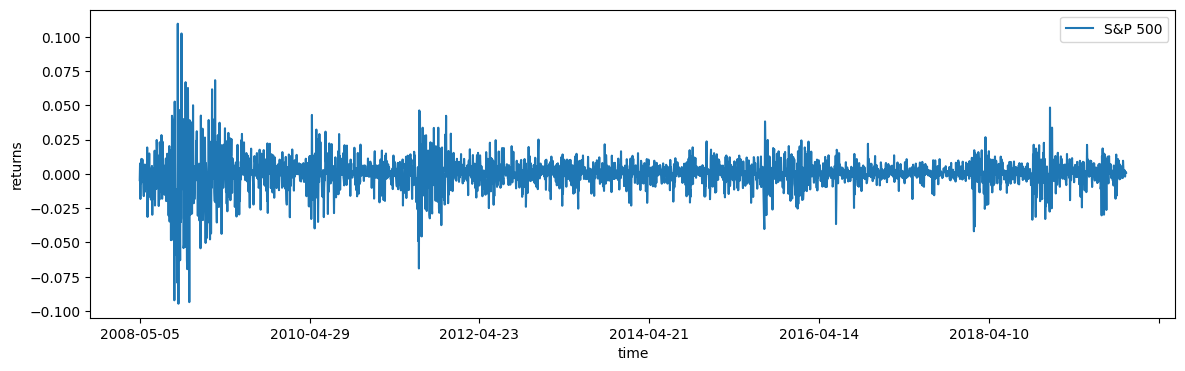

In [80]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

In [14]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/pymc/distributions/timeseries.py:292: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


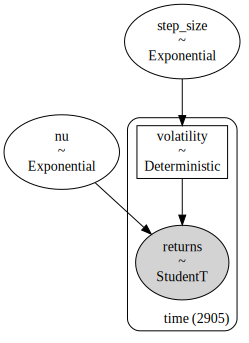

In [15]:
pm.model_to_graphviz(stochastic_vol_model)

In [16]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = idata.prior_predictive.stack(pooled_chain=("chain", "draw"))


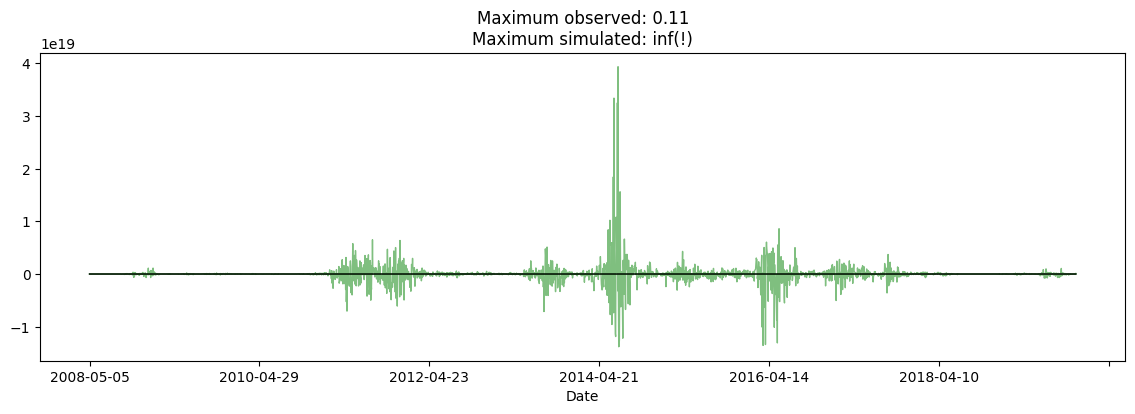

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [15]:
with stochastic_vol_model:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 891 seconds.
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


In [16]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))


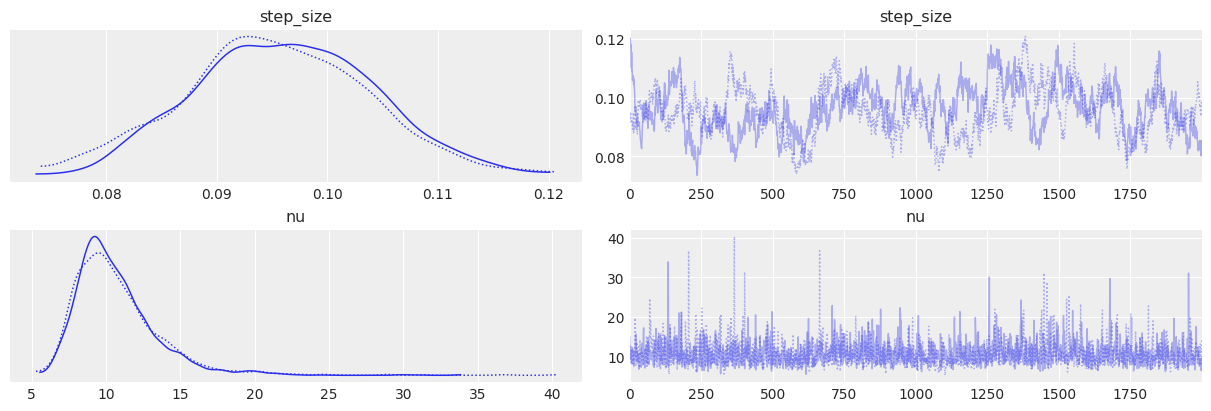

In [17]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

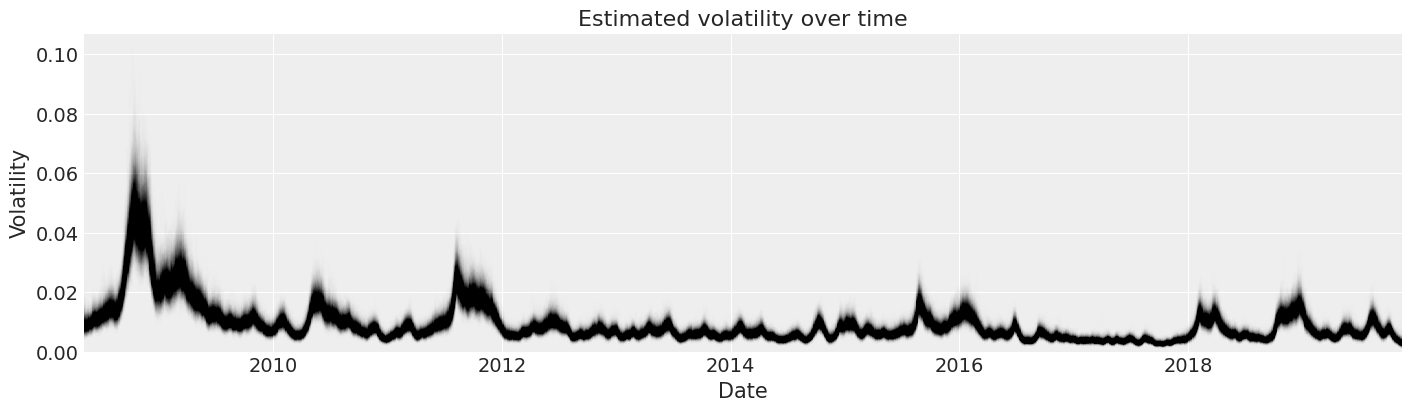

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

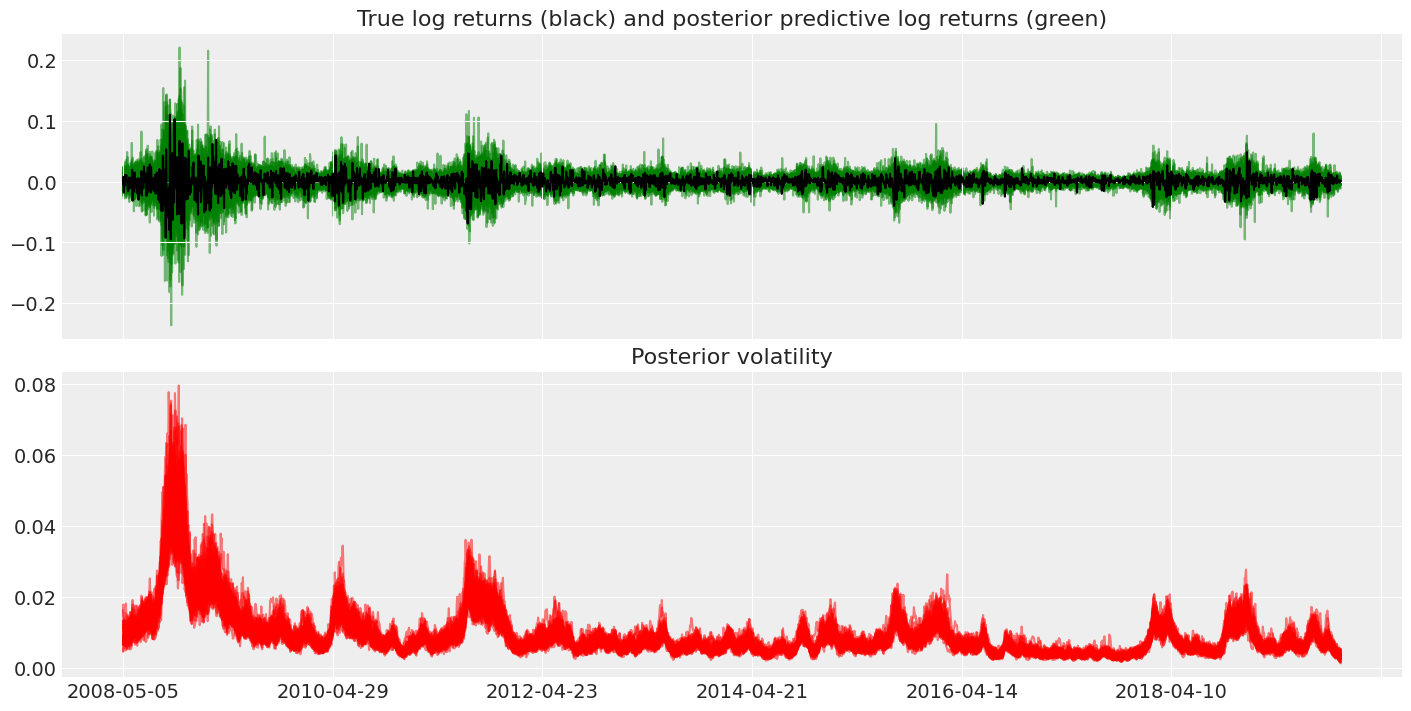

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"].isel(pooled_chain=slice(None, None, 100)),
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

# SGLD Torch Models

$X_i = log(r_i)$

$
p(s_i, \nu, \sigma | {\bf x}) = [\Pi_ip(x_i | s_i, \nu, \sigma) p(s_i | s_{i-1}, \sigma)] p(\nu) p(\sigma)
$

In [1577]:
class StochasticVolatility(nn.Module):
    EPSILON = 1e-6
    
    def __init__(self, shape, sigma_lambda=10., nu_lambda=0.1):
        '''
            Args:
                shape: shape of observed variables; first dim is batch_size
                sigma_lamda: rate parameter of Exponential prior RV of stepsize (aka sigma)
                nu_lamda: rate parameter of Exponential prior RV of degree freedom
        '''
        super(StochasticVolatility, self).__init__()
        self.shape = shape
        
        self.prior_sigma_rv = distributions.Exponential(sigma_lambda)
        self.sigma = nn.Parameter(torch.tensor(sigma_lambda))
        
        self.prior_nu_rv = distributions.Exponential(nu_lambda)
        self.nu = nn.Parameter(torch.tensor(nu_lambda))
        
        self.vol = nn.Parameter(torch.zeros(self.shape[1]))
        nn.init.normal_(self.vol, std=0.0001)
        
        self.init_vol = nn.Parameter(torch.tensor(-4.5))
      
    def returns_rv(self, vol_samples):
        # Uses \sigma parameterization, not \lambda as PyMC model above
        # See: https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_scaling_parameter_%CF%83%CC%82_or_%CF%83%CC%822
        rv = distributions.StudentT(df=(1 / (self.nu + self.EPSILON)) * torch.ones(vol_samples.shape), 
                                    loc=torch.zeros(vol_samples.shape), 
                                    scale=torch.exp(vol_samples) + self.EPSILON)
        return rv

    def forward(self):
        vol_rv = distributions.Normal(torch.stack([self.vol] * self.shape[0]),
                                      (1 / self.sigma) * torch.ones(self.shape))
        vol_diffs = vol_rv.rsample()
        vol_samples = self.init_vol + torch.cumsum(vol_diffs, dim=1)

        return self.returns_rv(vol_samples).mean, vol_samples

    def loss(self, r_obs, vol_samples):
        likelihood = self.returns_rv(vol_samples).log_prob(r_obs)
       
        vol_rv = distributions.Normal(loc=torch.zeros(vol_samples.shape),
                                      scale=(1 / self.sigma) * torch.ones(vol_samples.shape))
        vol_diffs = torch.diff(vol_samples - self.init_vol, append=torch.zeros(self.shape[0], 1)) 
        vol_prior = vol_rv.log_prob(vol_diffs)
       
        # Prior for each timestep
        sigma_prior = self.prior_sigma_rv.log_prob(1 / self.sigma)
        nu_prior = self.prior_nu_rv.log_prob(1 / self.nu)
        
        print(f'll = {likelihood.sum():.3f}, vol_prior = {vol_prior.sum():.3f}, sigma_prior = {sigma_prior.sum():.3f}, nu_prior = {nu_prior.sum():.3f}')
        return -(likelihood.sum() + vol_prior.sum() + sigma_prior.sum() + nu_prior.sum()) / np.prod(self.shape)

# Stochastic Gradient Descent

In [1653]:
batch_size = 10

torch_data = torch.tensor(returns['change'])
torch_data = torch.stack([torch_data] * batch_size, 0)

torch_data, torch_data.shape

(tensor([[-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         ...,
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
         [-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008]],
        dtype=torch.float64),
 torch.Size([10, 2905]))

ll = -74278.990, vol_prior = 5570.297, sigma_prior = 1.303, nu_prior = -3.303
torch_model.sigma.grad = -0.8604879379272461
torch_model.nu.grad = -35.595115661621094
[epoch=1] loss: 2.36526
ll = -312652.722, vol_prior = -359372.906, sigma_prior = 1.304, nu_prior = -3.212
torch_model.sigma.grad = 2.6292858123779297
torch_model.nu.grad = 0.16863076388835907
[epoch=2] loss: 23.13348
ll = -3954.080, vol_prior = 13989.846, sigma_prior = 1.303, nu_prior = -3.212
torch_model.sigma.grad = -0.5893009901046753
torch_model.nu.grad = -9.073488235473633
[epoch=3] loss: -0.34540
ll = 2807.403, vol_prior = 21377.688, sigma_prior = 1.303, nu_prior = -3.192
torch_model.sigma.grad = -0.6275519132614136
torch_model.nu.grad = -10.193140983581543
[epoch=4] loss: -0.83247
ll = -25925.715, vol_prior = 10290.491, sigma_prior = 1.303, nu_prior = -3.171
torch_model.sigma.grad = -0.35091209411621094
torch_model.nu.grad = -5.997295379638672
[epoch=5] loss: 0.53828
ll = -96884.398, vol_prior = 5739.132, sigma_prior

torch_model.sigma.grad = -0.428311824798584
torch_model.nu.grad = -1.5775126218795776
[epoch=41] loss: 0.49961
ll = -41845.104, vol_prior = 7579.849, sigma_prior = 1.308, nu_prior = -2.908
torch_model.sigma.grad = -0.6453502774238586
torch_model.nu.grad = -11.22068977355957
[epoch=42] loss: 1.17958
ll = -8931.633, vol_prior = 14493.485, sigma_prior = 1.309, nu_prior = -2.904
torch_model.sigma.grad = -0.6624294519424438
torch_model.nu.grad = -7.913782596588135
[epoch=43] loss: -0.19140
ll = -21438.357, vol_prior = 4352.656, sigma_prior = 1.309, nu_prior = -2.900
torch_model.sigma.grad = -0.7036502957344055
torch_model.nu.grad = -8.678366661071777
[epoch=44] loss: 0.58820
ll = -7447.437, vol_prior = 15515.423, sigma_prior = 1.309, nu_prior = -2.897
torch_model.sigma.grad = -0.4859769344329834
torch_model.nu.grad = -4.123827934265137
[epoch=45] loss: -0.27767
ll = -41420.953, vol_prior = 1176.026, sigma_prior = 1.309, nu_prior = -2.895
torch_model.sigma.grad = -0.7300072908401489
torch_mo

torch_model.sigma.grad = -0.9795399904251099
torch_model.nu.grad = -14.38546371459961
[epoch=79] loss: 2.02295
ll = -2514.526, vol_prior = 15897.535, sigma_prior = 1.313, nu_prior = -2.816
torch_model.sigma.grad = -0.2194277048110962
torch_model.nu.grad = -1.2107610702514648
[epoch=80] loss: -0.46064
ll = -53461.947, vol_prior = 2924.607, sigma_prior = 1.313, nu_prior = -2.815
torch_model.sigma.grad = -0.7192664742469788
torch_model.nu.grad = -7.641149044036865
[epoch=81] loss: 1.73972
ll = 11637.941, vol_prior = 14848.853, sigma_prior = 1.313, nu_prior = -2.813
torch_model.sigma.grad = -0.6190178394317627
torch_model.nu.grad = -5.720768928527832
[epoch=82] loss: -0.91171
ll = -29600.463, vol_prior = -233.645, sigma_prior = 1.313, nu_prior = -2.811
torch_model.sigma.grad = -0.44149476289749146
torch_model.nu.grad = -1.874008297920227
[epoch=83] loss: 1.02704
ll = -48383.473, vol_prior = 10748.396, sigma_prior = 1.313, nu_prior = -2.811
torch_model.sigma.grad = -0.7830340266227722
torch

ll = 11429.215, vol_prior = 15810.163, sigma_prior = 1.317, nu_prior = -2.756
torch_model.sigma.grad = -0.3802605867385864
torch_model.nu.grad = -1.6409538984298706
[epoch=118] loss: -0.93762
ll = -107018.743, vol_prior = -5339.542, sigma_prior = 1.317, nu_prior = -2.755
torch_model.sigma.grad = -0.9108062982559204
torch_model.nu.grad = -22.81180763244629
[epoch=119] loss: 3.86780
ll = -13713.604, vol_prior = 11176.657, sigma_prior = 1.317, nu_prior = -2.750
torch_model.sigma.grad = -0.40084603428840637
torch_model.nu.grad = -1.668796181678772
[epoch=120] loss: 0.08738
ll = 4448.140, vol_prior = 14025.708, sigma_prior = 1.317, nu_prior = -2.750
torch_model.sigma.grad = -0.570277214050293
torch_model.nu.grad = -5.061864376068115
[epoch=121] loss: -0.63588
ll = -26158.298, vol_prior = 17394.191, sigma_prior = 1.317, nu_prior = -2.749
torch_model.sigma.grad = -0.7302770614624023
torch_model.nu.grad = -4.882064342498779
[epoch=122] loss: 0.30174
ll = 10226.017, vol_prior = 17569.922, sigma

torch_model.sigma.grad = -0.6843410730361938
torch_model.nu.grad = -8.589428901672363
[epoch=157] loss: 0.35623
ll = -15782.817, vol_prior = 7494.694, sigma_prior = 1.321, nu_prior = -2.708
torch_model.sigma.grad = -0.15008661150932312
torch_model.nu.grad = 0.1359798014163971
[epoch=158] loss: 0.28535
ll = -6623.843, vol_prior = 7822.793, sigma_prior = 1.321, nu_prior = -2.708
torch_model.sigma.grad = -0.5948362350463867
torch_model.nu.grad = -7.551438331604004
[epoch=159] loss: -0.04122
ll = 21860.613, vol_prior = 16708.314, sigma_prior = 1.321, nu_prior = -2.707
torch_model.sigma.grad = -0.5242399573326111
torch_model.nu.grad = -3.8698601722717285
[epoch=160] loss: -1.32763
ll = 1264.889, vol_prior = 16626.490, sigma_prior = 1.321, nu_prior = -2.706
torch_model.sigma.grad = -0.24633857607841492
torch_model.nu.grad = -0.5569660067558289
[epoch=161] loss: -0.61583
ll = -42048.484, vol_prior = -447.547, sigma_prior = 1.321, nu_prior = -2.706
torch_model.sigma.grad = -0.7947348356246948


torch_model.sigma.grad = -0.4980265498161316
torch_model.nu.grad = -10.29586124420166
[epoch=195] loss: 1.39706
ll = -79082.033, vol_prior = -5251.901, sigma_prior = 1.325, nu_prior = -2.672
torch_model.sigma.grad = -0.909130871295929
torch_model.nu.grad = -15.694284439086914
[epoch=196] loss: 2.90311
ll = -14062.835, vol_prior = 17323.662, sigma_prior = 1.325, nu_prior = -2.670
torch_model.sigma.grad = -0.5337538123130798
torch_model.nu.grad = -4.15308141708374
[epoch=197] loss: -0.11220
ll = -33759.883, vol_prior = -3048.834, sigma_prior = 1.325, nu_prior = -2.669
torch_model.sigma.grad = -0.40360593795776367
torch_model.nu.grad = -0.9411104917526245
[epoch=198] loss: 1.26713
ll = -7744.796, vol_prior = 12265.283, sigma_prior = 1.325, nu_prior = -2.669
torch_model.sigma.grad = -0.6330729126930237
torch_model.nu.grad = -4.065088748931885
[epoch=199] loss: -0.15556
ll = 15842.941, vol_prior = 13769.098, sigma_prior = 1.325, nu_prior = -2.668
torch_model.sigma.grad = -0.5632792711257935

ll = 23159.489, vol_prior = 21091.834, sigma_prior = 1.328, nu_prior = -2.644
torch_model.sigma.grad = -0.38481301069259644
torch_model.nu.grad = -3.286097526550293
[epoch=235] loss: -1.52324
ll = 8447.195, vol_prior = 12596.614, sigma_prior = 1.328, nu_prior = -2.643
torch_model.sigma.grad = -0.4871951639652252
torch_model.nu.grad = -4.41758918762207
[epoch=236] loss: -0.72435
ll = -17788.221, vol_prior = 9524.551, sigma_prior = 1.328, nu_prior = -2.643
torch_model.sigma.grad = -0.5528547763824463
torch_model.nu.grad = -3.360318660736084
[epoch=237] loss: 0.28451
ll = 9489.075, vol_prior = 10389.570, sigma_prior = 1.328, nu_prior = -2.642
torch_model.sigma.grad = -0.525974452495575
torch_model.nu.grad = -3.715496063232422
[epoch=238] loss: -0.68425
ll = -34934.190, vol_prior = 9110.212, sigma_prior = 1.328, nu_prior = -2.642
torch_model.sigma.grad = -0.3655070960521698
torch_model.nu.grad = 0.1237645372748375
[epoch=239] loss: 0.88899
ll = 11813.865, vol_prior = 9235.208, sigma_prior 

ll = -45573.751, vol_prior = 508.932, sigma_prior = 1.331, nu_prior = -2.620
torch_model.sigma.grad = -0.5238642692565918
torch_model.nu.grad = -3.842538356781006
[epoch=274] loss: 1.55133
ll = 37974.261, vol_prior = 12082.006, sigma_prior = 1.331, nu_prior = -2.619
torch_model.sigma.grad = -0.3278801739215851
torch_model.nu.grad = -4.7479424476623535
[epoch=275] loss: -1.72306
ll = -3196.287, vol_prior = 11589.531, sigma_prior = 1.331, nu_prior = -2.618
torch_model.sigma.grad = -0.5468567609786987
torch_model.nu.grad = -3.8481059074401855
[epoch=276] loss: -0.28888
ll = 7694.728, vol_prior = 16379.932, sigma_prior = 1.331, nu_prior = -2.618
torch_model.sigma.grad = -0.48764732480049133
torch_model.nu.grad = -2.3456196784973145
[epoch=277] loss: -0.82869
ll = 24938.982, vol_prior = 19766.596, sigma_prior = 1.332, nu_prior = -2.617
torch_model.sigma.grad = -0.346316397190094
torch_model.nu.grad = -1.657241702079773
[epoch=278] loss: -1.53887
ll = 31802.886, vol_prior = 14821.845, sigma_

ll = 6283.066, vol_prior = 13279.919, sigma_prior = 1.334, nu_prior = -2.600
torch_model.sigma.grad = -0.5309665203094482
torch_model.nu.grad = -4.634819984436035
[epoch=312] loss: -0.67338
ll = 16502.436, vol_prior = 15183.705, sigma_prior = 1.335, nu_prior = -2.600
torch_model.sigma.grad = -0.3844989538192749
torch_model.nu.grad = -1.207894206047058
[epoch=313] loss: -1.09070
ll = 31997.061, vol_prior = 7880.028, sigma_prior = 1.335, nu_prior = -2.599
torch_model.sigma.grad = -0.3633121848106384
torch_model.nu.grad = -3.1784474849700928
[epoch=314] loss: -1.37266
ll = 2761.286, vol_prior = 2770.948, sigma_prior = 1.335, nu_prior = -2.599
torch_model.sigma.grad = -0.34311336278915405
torch_model.nu.grad = -0.5066736936569214
[epoch=315] loss: -0.19039
ll = -24465.346, vol_prior = 6488.533, sigma_prior = 1.335, nu_prior = -2.599
torch_model.sigma.grad = -0.6333544254302979
torch_model.nu.grad = -8.222465515136719
[epoch=316] loss: 0.61887
ll = -37203.821, vol_prior = 8774.553, sigma_pr

ll = 10682.774, vol_prior = 12752.454, sigma_prior = 1.338, nu_prior = -2.581
torch_model.sigma.grad = -0.4293135702610016
torch_model.nu.grad = -1.741801381111145
[epoch=350] loss: -0.80668
ll = -8216.325, vol_prior = 9316.020, sigma_prior = 1.338, nu_prior = -2.580
torch_model.sigma.grad = -0.5253600478172302
torch_model.nu.grad = -7.081511497497559
[epoch=351] loss: -0.03781
ll = -7675.132, vol_prior = 6964.298, sigma_prior = 1.338, nu_prior = -2.579
torch_model.sigma.grad = -0.3890065550804138
torch_model.nu.grad = -1.4940074682235718
[epoch=352] loss: 0.02451
ll = 35229.324, vol_prior = 18842.531, sigma_prior = 1.338, nu_prior = -2.579
torch_model.sigma.grad = -0.35535770654678345
torch_model.nu.grad = -0.12021785974502563
[epoch=353] loss: -1.86129
ll = 7311.939, vol_prior = 10698.678, sigma_prior = 1.338, nu_prior = -2.579
torch_model.sigma.grad = -0.3234836161136627
torch_model.nu.grad = -5.900786399841309
[epoch=354] loss: -0.61994
ll = 29864.331, vol_prior = 19057.496, sigma_

ll = 13563.212, vol_prior = 13829.262, sigma_prior = 1.341, nu_prior = -2.564
torch_model.sigma.grad = -0.47812747955322266
torch_model.nu.grad = -3.6784005165100098
[epoch=388] loss: -0.94290
ll = 26061.510, vol_prior = 18293.426, sigma_prior = 1.341, nu_prior = -2.564
torch_model.sigma.grad = -0.3458928167819977
torch_model.nu.grad = -0.8231953382492065
[epoch=389] loss: -1.52681
ll = -9927.430, vol_prior = 569.838, sigma_prior = 1.341, nu_prior = -2.564
torch_model.sigma.grad = -0.5563136339187622
torch_model.nu.grad = -8.427830696105957
[epoch=390] loss: 0.32216
ll = -51422.108, vol_prior = -23912.949, sigma_prior = 1.341, nu_prior = -2.562
torch_model.sigma.grad = -0.22411608695983887
torch_model.nu.grad = 0.21711325645446777
[epoch=391] loss: 2.59333
ll = 3518.778, vol_prior = 4163.193, sigma_prior = 1.341, nu_prior = -2.563
torch_model.sigma.grad = -0.4609614610671997
torch_model.nu.grad = -6.244144439697266
[epoch=392] loss: -0.26440
ll = -9139.867, vol_prior = -2322.255, sigma

[epoch=425] loss: -1.62308
ll = -6853.534, vol_prior = 5526.432, sigma_prior = 1.344, nu_prior = -2.549
torch_model.sigma.grad = -0.48346856236457825
torch_model.nu.grad = -3.9237537384033203
[epoch=426] loss: 0.04572
ll = 35950.521, vol_prior = 10959.216, sigma_prior = 1.344, nu_prior = -2.549
torch_model.sigma.grad = -0.41995298862457275
torch_model.nu.grad = -2.288900136947632
[epoch=427] loss: -1.61475
ll = -14949.384, vol_prior = 9252.293, sigma_prior = 1.344, nu_prior = -2.548
torch_model.sigma.grad = -0.4325721859931946
torch_model.nu.grad = -4.407730579376221
[epoch=428] loss: 0.19615
ll = -51539.650, vol_prior = -7302.347, sigma_prior = 1.344, nu_prior = -2.548
torch_model.sigma.grad = -0.47081756591796875
torch_model.nu.grad = -5.020034313201904
[epoch=429] loss: 2.02558
ll = 41429.663, vol_prior = 15372.999, sigma_prior = 1.344, nu_prior = -2.547
torch_model.sigma.grad = -0.33424854278564453
torch_model.nu.grad = -1.0281673669815063
[epoch=430] loss: -1.95530
ll = -13730.781

torch_model.sigma.grad = -0.2163946032524109
torch_model.nu.grad = -0.38880452513694763
[epoch=464] loss: -1.88580
ll = 7299.196, vol_prior = 6862.976, sigma_prior = 1.347, nu_prior = -2.535
torch_model.sigma.grad = -0.613288402557373
torch_model.nu.grad = -4.368144989013672
[epoch=465] loss: -0.48747
ll = -5265.660, vol_prior = -2622.404, sigma_prior = 1.347, nu_prior = -2.535
torch_model.sigma.grad = -0.24036993086338043
torch_model.nu.grad = -0.2258586883544922
[epoch=466] loss: 0.27157
ll = -11659.132, vol_prior = 7151.505, sigma_prior = 1.347, nu_prior = -2.535
torch_model.sigma.grad = -0.5806710720062256
torch_model.nu.grad = -4.7878336906433105
[epoch=467] loss: 0.15521
ll = 7572.364, vol_prior = 6339.498, sigma_prior = 1.348, nu_prior = -2.534
torch_model.sigma.grad = -0.31439363956451416
torch_model.nu.grad = -0.4522205889225006
[epoch=468] loss: -0.47885
ll = 3320.629, vol_prior = 9949.034, sigma_prior = 1.348, nu_prior = -2.534
torch_model.sigma.grad = -0.5113335251808167
to

ll = 59342.444, vol_prior = 21811.016, sigma_prior = 1.350, nu_prior = -2.523
torch_model.sigma.grad = -0.23373743891716003
torch_model.nu.grad = -0.7858062386512756
[epoch=504] loss: -2.79354
ll = 11863.767, vol_prior = 6779.269, sigma_prior = 1.350, nu_prior = -2.523
torch_model.sigma.grad = -0.3448738157749176
torch_model.nu.grad = -0.6637395024299622
[epoch=505] loss: -0.64172
ll = 6659.682, vol_prior = 6199.522, sigma_prior = 1.351, nu_prior = -2.523
torch_model.sigma.grad = -0.4748285710811615
torch_model.nu.grad = -3.476623773574829
[epoch=506] loss: -0.44262
ll = 33495.927, vol_prior = 14609.920, sigma_prior = 1.351, nu_prior = -2.522
torch_model.sigma.grad = -0.3803270757198334
torch_model.nu.grad = -2.8348512649536133
[epoch=507] loss: -1.65593
ll = 9117.891, vol_prior = -5607.255, sigma_prior = 1.351, nu_prior = -2.522
torch_model.sigma.grad = -0.43808650970458984
torch_model.nu.grad = -1.5748789310455322
[epoch=508] loss: -0.12081
ll = 17819.512, vol_prior = 17406.346, sigm

torch_model.sigma.grad = -0.4234027862548828
torch_model.nu.grad = -1.453800916671753
[epoch=543] loss: -0.60200
ll = 25426.928, vol_prior = 10326.688, sigma_prior = 1.354, nu_prior = -2.512
torch_model.sigma.grad = -0.37579381465911865
torch_model.nu.grad = -2.561523675918579
[epoch=544] loss: -1.23072
ll = 11352.352, vol_prior = 10228.166, sigma_prior = 1.354, nu_prior = -2.511
torch_model.sigma.grad = -0.4612996578216553
torch_model.nu.grad = -2.5325000286102295
[epoch=545] loss: -0.74284
ll = 25829.231, vol_prior = 16895.213, sigma_prior = 1.354, nu_prior = -2.511
torch_model.sigma.grad = -0.380280077457428
torch_model.nu.grad = -1.4114594459533691
[epoch=546] loss: -1.47068
ll = 14280.059, vol_prior = 3606.555, sigma_prior = 1.354, nu_prior = -2.511
torch_model.sigma.grad = -0.4238601326942444
torch_model.nu.grad = -2.9263720512390137
[epoch=547] loss: -0.61568
ll = 6757.248, vol_prior = 10881.029, sigma_prior = 1.354, nu_prior = -2.510
torch_model.sigma.grad = -0.4658108949661255

ll = 30649.302, vol_prior = 16970.004, sigma_prior = 1.357, nu_prior = -2.502
torch_model.sigma.grad = -0.3800860345363617
torch_model.nu.grad = -1.508533000946045
[epoch=582] loss: -1.63918
ll = 35788.138, vol_prior = 16154.809, sigma_prior = 1.357, nu_prior = -2.501
torch_model.sigma.grad = -0.3350290060043335
torch_model.nu.grad = -0.6545639038085938
[epoch=583] loss: -1.78801
ll = 21659.253, vol_prior = 21616.316, sigma_prior = 1.357, nu_prior = -2.501
torch_model.sigma.grad = -0.4563082754611969
torch_model.nu.grad = -3.650709390640259
[epoch=584] loss: -1.48965
ll = 3242.749, vol_prior = -2406.522, sigma_prior = 1.357, nu_prior = -2.501
torch_model.sigma.grad = -0.2701815962791443
torch_model.nu.grad = -0.09743254631757736
[epoch=585] loss: -0.02875
ll = 31643.398, vol_prior = 16594.438, sigma_prior = 1.357, nu_prior = -2.501
torch_model.sigma.grad = -0.36620861291885376
torch_model.nu.grad = -1.7757083177566528
[epoch=586] loss: -1.66047
ll = 22231.989, vol_prior = 14943.494, si

ll = 4271.560, vol_prior = 4034.769, sigma_prior = 1.360, nu_prior = -2.493
torch_model.sigma.grad = -0.42023566365242004
torch_model.nu.grad = -5.0132646560668945
[epoch=621] loss: -0.28589
ll = 13237.953, vol_prior = 6569.736, sigma_prior = 1.360, nu_prior = -2.492
torch_model.sigma.grad = -0.4014899730682373
torch_model.nu.grad = -1.8197373151779175
[epoch=622] loss: -0.68181
ll = 16333.962, vol_prior = 13379.507, sigma_prior = 1.360, nu_prior = -2.492
torch_model.sigma.grad = -0.24501101672649384
torch_model.nu.grad = -0.08900328725576401
[epoch=623] loss: -1.02280
ll = 31043.823, vol_prior = 10218.572, sigma_prior = 1.360, nu_prior = -2.492
torch_model.sigma.grad = -0.3271937966346741
torch_model.nu.grad = -2.7344157695770264
[epoch=624] loss: -1.42035
ll = 44535.369, vol_prior = 24921.891, sigma_prior = 1.360, nu_prior = -2.492
torch_model.sigma.grad = -0.2769297659397125
torch_model.nu.grad = -0.6298137903213501
[epoch=625] loss: -2.39092
ll = 50559.744, vol_prior = 21897.258, s

torch_model.sigma.grad = -0.42850762605667114
torch_model.nu.grad = -4.399578094482422
[epoch=658] loss: -0.10680
ll = -12971.304, vol_prior = 5277.554, sigma_prior = 1.363, nu_prior = -2.484
torch_model.sigma.grad = -0.34884828329086304
torch_model.nu.grad = -1.0773862600326538
[epoch=659] loss: 0.26488
ll = 48549.285, vol_prior = 17327.531, sigma_prior = 1.363, nu_prior = -2.484
torch_model.sigma.grad = -0.3125537931919098
torch_model.nu.grad = -1.1640514135360718
[epoch=660] loss: -2.26767
ll = 5641.616, vol_prior = 5110.288, sigma_prior = 1.363, nu_prior = -2.483
torch_model.sigma.grad = -0.48635661602020264
torch_model.nu.grad = -2.328070640563965
[epoch=661] loss: -0.37008
ll = 35430.245, vol_prior = 15056.562, sigma_prior = 1.363, nu_prior = -2.483
torch_model.sigma.grad = -0.3203224837779999
torch_model.nu.grad = -0.7242197394371033
[epoch=662] loss: -1.73789
ll = 22339.741, vol_prior = 17341.602, sigma_prior = 1.363, nu_prior = -2.483
torch_model.sigma.grad = -0.34228277206420

ll = 50733.588, vol_prior = 14938.621, sigma_prior = 1.366, nu_prior = -2.476
torch_model.sigma.grad = -0.30007240176200867
torch_model.nu.grad = -0.6828482151031494
[epoch=696] loss: -2.26062
ll = 9074.376, vol_prior = 7956.985, sigma_prior = 1.366, nu_prior = -2.476
torch_model.sigma.grad = -0.37016600370407104
torch_model.nu.grad = -4.042606830596924
[epoch=697] loss: -0.58624
ll = 26928.378, vol_prior = 10973.076, sigma_prior = 1.366, nu_prior = -2.476
torch_model.sigma.grad = -0.3750576078891754
torch_model.nu.grad = -1.2513147592544556
[epoch=698] loss: -1.30466
ll = 41872.415, vol_prior = 8740.578, sigma_prior = 1.366, nu_prior = -2.476
torch_model.sigma.grad = -0.265445351600647
torch_model.nu.grad = -0.4888773560523987
[epoch=699] loss: -1.74223
ll = 24182.145, vol_prior = 17475.098, sigma_prior = 1.366, nu_prior = -2.476
torch_model.sigma.grad = -0.378406822681427
torch_model.nu.grad = -0.9692056775093079
[epoch=700] loss: -1.43395
ll = 53137.841, vol_prior = 14722.383, sigma

ll = 35825.893, vol_prior = 17616.318, sigma_prior = 1.369, nu_prior = -2.470
torch_model.sigma.grad = -0.34713199734687805
torch_model.nu.grad = -1.306822419166565
[epoch=734] loss: -1.83963
ll = 61544.318, vol_prior = 22051.410, sigma_prior = 1.369, nu_prior = -2.470
torch_model.sigma.grad = -0.2548840343952179
torch_model.nu.grad = -0.74365234375
[epoch=735] loss: -2.87761
ll = 24418.732, vol_prior = 12629.121, sigma_prior = 1.369, nu_prior = -2.470
torch_model.sigma.grad = -0.34307217597961426
torch_model.nu.grad = -0.9293789267539978
[epoch=736] loss: -1.27528
ll = 40315.423, vol_prior = 17262.482, sigma_prior = 1.369, nu_prior = -2.470
torch_model.sigma.grad = -0.3434617519378662
torch_model.nu.grad = -1.2375794649124146
[epoch=737] loss: -1.98199
ll = 24814.077, vol_prior = 5620.466, sigma_prior = 1.369, nu_prior = -2.469
torch_model.sigma.grad = -0.31839144229888916
torch_model.nu.grad = -2.5757510662078857
[epoch=738] loss: -1.04762
ll = 30923.920, vol_prior = 15726.350, sigma

ll = 24411.282, vol_prior = 14104.037, sigma_prior = 1.372, nu_prior = -2.463
torch_model.sigma.grad = -0.3574865460395813
torch_model.nu.grad = -2.788060188293457
[epoch=772] loss: -1.32579
ll = 49099.600, vol_prior = 21869.375, sigma_prior = 1.372, nu_prior = -2.463
torch_model.sigma.grad = -0.28161513805389404
torch_model.nu.grad = -0.6079397201538086
[epoch=773] loss: -2.44296
ll = 45124.802, vol_prior = 13515.948, sigma_prior = 1.372, nu_prior = -2.463
torch_model.sigma.grad = -0.2955314815044403
torch_model.nu.grad = -1.2124004364013672
[epoch=774] loss: -2.01858
ll = 45412.994, vol_prior = 16919.293, sigma_prior = 1.372, nu_prior = -2.463
torch_model.sigma.grad = -0.30358898639678955
torch_model.nu.grad = -0.7176955938339233
[epoch=775] loss: -2.14565
ll = 23799.273, vol_prior = 11978.530, sigma_prior = 1.372, nu_prior = -2.463
torch_model.sigma.grad = -0.2773107886314392
torch_model.nu.grad = -3.445690393447876
[epoch=776] loss: -1.23156
ll = 38904.294, vol_prior = 19045.027, s

ll = 34710.478, vol_prior = 17838.434, sigma_prior = 1.375, nu_prior = -2.457
torch_model.sigma.grad = -0.3629015386104584
torch_model.nu.grad = -1.644513726234436
[epoch=810] loss: -1.80888
ll = 21570.649, vol_prior = 18740.582, sigma_prior = 1.375, nu_prior = -2.457
torch_model.sigma.grad = -0.3847777843475342
torch_model.nu.grad = -1.1008726358413696
[epoch=811] loss: -1.38761
ll = 13656.882, vol_prior = 9273.259, sigma_prior = 1.375, nu_prior = -2.457
torch_model.sigma.grad = -0.37483352422714233
torch_model.nu.grad = -1.2027641534805298
[epoch=812] loss: -0.78930
ll = 26586.975, vol_prior = 11666.322, sigma_prior = 1.375, nu_prior = -2.457
torch_model.sigma.grad = -0.3551396429538727
torch_model.nu.grad = -2.4527320861816406
[epoch=813] loss: -1.31677
ll = 45542.764, vol_prior = 20696.855, sigma_prior = 1.375, nu_prior = -2.457
torch_model.sigma.grad = -0.2629704773426056
torch_model.nu.grad = -0.5377165675163269
[epoch=814] loss: -2.28016
ll = 36796.032, vol_prior = 18116.031, si

torch_model.sigma.grad = -0.28188493847846985
torch_model.nu.grad = -1.6743332147598267
[epoch=848] loss: -2.19694
ll = 34152.861, vol_prior = 409.397, sigma_prior = 1.378, nu_prior = -2.451
torch_model.sigma.grad = -0.34921523928642273
torch_model.nu.grad = -0.7821505665779114
[epoch=849] loss: -1.18971
ll = 30558.590, vol_prior = 18389.953, sigma_prior = 1.378, nu_prior = -2.451
torch_model.sigma.grad = -0.3064843416213989
torch_model.nu.grad = -0.8366116285324097
[epoch=850] loss: -1.68494
ll = 43254.496, vol_prior = 19035.035, sigma_prior = 1.378, nu_prior = -2.451
torch_model.sigma.grad = -0.2814786732196808
torch_model.nu.grad = -1.2639477252960205
[epoch=851] loss: -2.14418
ll = 51073.208, vol_prior = 16875.645, sigma_prior = 1.378, nu_prior = -2.451
torch_model.sigma.grad = -0.2913517951965332
torch_model.nu.grad = -0.3114528954029083
[epoch=852] loss: -2.33899
ll = 1911.012, vol_prior = 4001.506, sigma_prior = 1.378, nu_prior = -2.451
torch_model.sigma.grad = -0.26237916946411

torch_model.sigma.grad = -0.3519938588142395
torch_model.nu.grad = -1.3670849800109863
[epoch=885] loss: -1.44724
ll = 22469.742, vol_prior = 12187.459, sigma_prior = 1.381, nu_prior = -2.446
torch_model.sigma.grad = -0.4008978307247162
torch_model.nu.grad = -1.528741478919983
[epoch=886] loss: -1.19298
ll = 26487.927, vol_prior = 15044.023, sigma_prior = 1.381, nu_prior = -2.446
torch_model.sigma.grad = -0.31600308418273926
torch_model.nu.grad = -0.5737273693084717
[epoch=887] loss: -1.42963
ll = 26929.123, vol_prior = 17238.914, sigma_prior = 1.381, nu_prior = -2.445
torch_model.sigma.grad = -0.3477628827095032
torch_model.nu.grad = -1.184235692024231
[epoch=888] loss: -1.52038
ll = 35196.617, vol_prior = 15650.048, sigma_prior = 1.381, nu_prior = -2.445
torch_model.sigma.grad = -0.3118959963321686
torch_model.nu.grad = -1.8774218559265137
[epoch=889] loss: -1.75028
ll = 20492.793, vol_prior = 9493.488, sigma_prior = 1.381, nu_prior = -2.445
torch_model.sigma.grad = -0.39151066541671

ll = 13174.372, vol_prior = -1061.002, sigma_prior = 1.384, nu_prior = -2.440
torch_model.sigma.grad = -0.3094610869884491
torch_model.nu.grad = -2.2465078830718994
[epoch=925] loss: -0.41695
ll = 32312.269, vol_prior = 10844.563, sigma_prior = 1.384, nu_prior = -2.440
torch_model.sigma.grad = -0.3248138725757599
torch_model.nu.grad = -1.635260820388794
[epoch=926] loss: -1.48557
ll = 33821.381, vol_prior = 15751.606, sigma_prior = 1.384, nu_prior = -2.440
torch_model.sigma.grad = -0.35682517290115356
torch_model.nu.grad = -1.2556822299957275
[epoch=927] loss: -1.70643
ll = 51015.750, vol_prior = 19001.186, sigma_prior = 1.384, nu_prior = -2.440
torch_model.sigma.grad = -0.26764023303985596
torch_model.nu.grad = -0.5148720741271973
[epoch=928] loss: -2.41019
ll = 18388.421, vol_prior = 11075.140, sigma_prior = 1.384, nu_prior = -2.440
torch_model.sigma.grad = -0.3662155568599701
torch_model.nu.grad = -1.9872075319290161
[epoch=929] loss: -1.01420
ll = 37302.273, vol_prior = 9475.081, s

torch_model.sigma.grad = -0.31884366273880005
torch_model.nu.grad = -0.5398371815681458
[epoch=963] loss: -1.28660
ll = 12712.850, vol_prior = 7350.331, sigma_prior = 1.387, nu_prior = -2.436
torch_model.sigma.grad = -0.34589439630508423
torch_model.nu.grad = -2.4253592491149902
[epoch=964] loss: -0.69061
ll = 44158.227, vol_prior = 18871.182, sigma_prior = 1.387, nu_prior = -2.435
torch_model.sigma.grad = -0.3135867416858673
torch_model.nu.grad = -0.9246503114700317
[epoch=965] loss: -2.16965
ll = 2106.752, vol_prior = -4152.036, sigma_prior = 1.387, nu_prior = -2.435
torch_model.sigma.grad = -0.3404915928840637
torch_model.nu.grad = -2.8843986988067627
[epoch=966] loss: 0.07044
ll = 43765.562, vol_prior = 16499.408, sigma_prior = 1.387, nu_prior = -2.435
torch_model.sigma.grad = -0.2987762689590454
torch_model.nu.grad = -0.9940407872200012
[epoch=967] loss: -2.07449
ll = 29195.942, vol_prior = 11274.930, sigma_prior = 1.387, nu_prior = -2.435
torch_model.sigma.grad = -0.3384018540382

<AxesSubplot: >

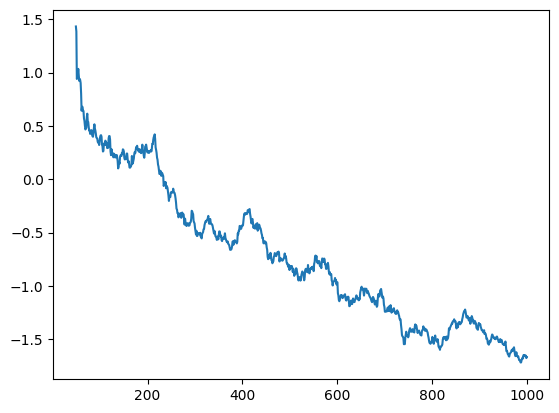

In [1654]:
torch_model = StochasticVolatility(torch_data.shape, sigma_lambda=10., nu_lambda=0.1)
lr = 0.001
param_group_1 = [p for name, p in torch_model.named_parameters() if name not in {'init_vol', 'sigma', 'nu'}]
param_group_2 = [torch_model.init_vol]
param_group_3 = [torch_model.sigma]
param_group_4 = [torch_model.nu]
optimizer = optim.RMSprop(torch_model.parameters(), lr=lr)

epoch = 0
loss_seq = []
for epoch in range(1000):
    torch_model.zero_grad()
    
    r_samples, vol_samples = torch_model()
    loss = torch_model.loss(torch_data, vol_samples)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(torch_model.sigma, max_norm=50.)
    print(f'torch_model.sigma.grad = {torch_model.sigma.grad}')
    print(f'torch_model.nu.grad = {torch_model.nu.grad}')
        
    optimizer.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}')
    print(f'========================================')
    loss_seq.append(loss.item())
        
for name, param in torch_model.named_parameters():
    print(f'{name} = {param}')
    if name in {'sigma', 'nu'}:
        print(f' * 1 / {name} = {1 / param}')

loss_seq = pd.Series(loss_seq)
loss_seq.rolling(50).mean().plot()

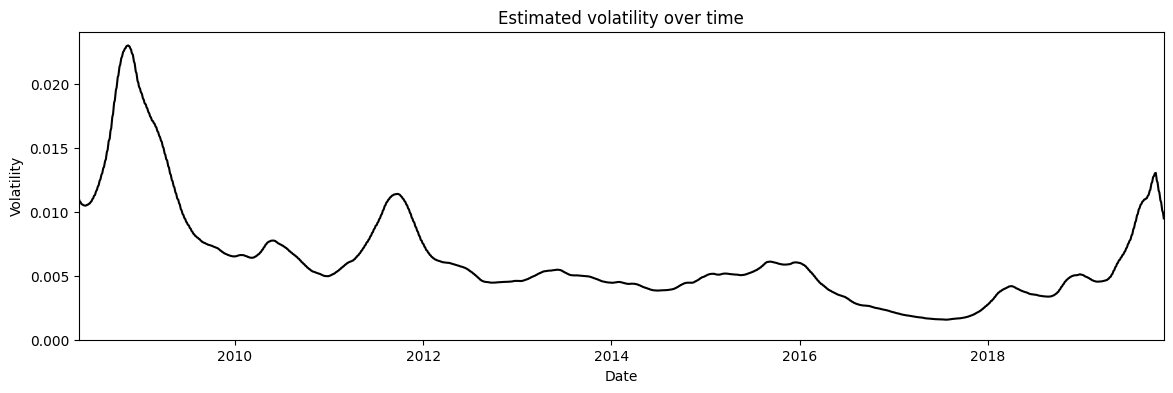

In [1656]:
sigma_rv = distributions.Exponential(torch_model.sigma)
sigma_mean = sigma_rv.mean

vol_mean = torch_model.init_vol + torch.cumsum(torch_model.vol, dim=0) 

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_mean.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k")#, alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

# Stochastic Gradient Langevin Dynamics

In [1663]:
class SGLD(torch.optim.RMSprop):
    def __init__(self, *args, **kwargs):
        super(SGLD, self).__init__(*args, **kwargs)
        
    def step(self, *args, **kwargs):
        loss = super().step(*args, **kwargs)
        
        for group in self.param_groups:
            assert group['momentum'] == 0, "momentum not supported"
            assert group['centered'] == 0, "centered not supported"
            assert group['weight_decay'] == 0, "weight_decay not supported"
            
            lr = group['lr']
            
            for p in group['params']:
                assert not torch.is_complex(p), "complex not supported"
                state = self.state[p]
                grad = p.grad 
                square_avg = state['square_avg']
            
                avg = square_avg.sqrt()
                avg = avg.add_(group['eps'])
            
                effective_lr = -2 * lr / avg
                m = distributions.Normal(torch.zeros(p.shape), torch.ones(p.shape))
                noise = m.sample() * effective_lr.sqrt()
                p = p + noise
        
        return loss

In [1664]:
def compute_lr(epoch, start=1.0, end=0.0001, gamma=0.55, batch_size=1):
    b = 1e4 / ((end / start) ** (-1 / gamma)) 
    a = start * (b ** gamma)
    return a * ((b + epoch) ** (-gamma))

print(f't=0:     {compute_lr(0):4f}\nt=10000: {compute_lr(10000 * 1 ):4f}')
print(f't=0:     {compute_lr(0):4f}\nt=100000: {compute_lr(10000 * 10):4f}')
print(f't=0:     {compute_lr(0):4f}\nt=1000000: {compute_lr(10000 * 100):4f}')

t=0:     1.000000
t=10000: 0.000100
t=0:     1.000000
t=100000: 0.000028
t=0:     1.000000
t=1000000: 0.000008


ll = -19937.458, vol_prior = 3625.929, sigma_prior = 1.303, nu_prior = -3.303
sgld_model.sigma.grad = -0.6401015520095825
sgld_model.nu.grad = -9.283981323242188
[epoch=1] loss: 0.56157, last_lr: [1e-06]
ll = -389810.764, vol_prior = -43118.113, sigma_prior = 1.304, nu_prior = -3.212
sgld_model.sigma.grad = -0.6018766164779663
sgld_model.nu.grad = -123.07560729980469
[epoch=2] loss: 14.90295, last_lr: [1e-06]
ll = -403783.572, vol_prior = -269531.562, sigma_prior = 1.304, nu_prior = -3.136
sgld_model.sigma.grad = 1.4747314453125
sgld_model.nu.grad = 0.20497940480709076
[epoch=3] loss: 23.17786, last_lr: [1e-06]
ll = -159846.254, vol_prior = -11912.630, sigma_prior = 1.303, nu_prior = -3.136
sgld_model.sigma.grad = -0.19530647993087769
sgld_model.nu.grad = 0.16686959564685822
[epoch=4] loss: 5.91259, last_lr: [1e-06]
ll = -100676.101, vol_prior = 6226.984, sigma_prior = 1.304, nu_prior = -3.136
sgld_model.sigma.grad = -0.5124460458755493
sgld_model.nu.grad = -23.628435134887695
[epoch=5

[epoch=34] loss: 1.42107, last_lr: [1e-06]
ll = -14601.369, vol_prior = 18827.738, sigma_prior = 1.309, nu_prior = -2.996
sgld_model.sigma.grad = -0.5539649128913879
sgld_model.nu.grad = -7.395186901092529
[epoch=35] loss: -0.14543, last_lr: [1e-06]
ll = -21830.845, vol_prior = 7627.439, sigma_prior = 1.310, nu_prior = -2.993
sgld_model.sigma.grad = -0.29567551612854004
sgld_model.nu.grad = -0.6578545570373535
[epoch=36] loss: 0.48899, last_lr: [1e-06]
ll = -58760.850, vol_prior = -414.702, sigma_prior = 1.310, nu_prior = -2.992
sgld_model.sigma.grad = -0.9107961654663086
sgld_model.nu.grad = -30.54726791381836
[epoch=37] loss: 2.03708, last_lr: [1e-06]
ll = -78936.635, vol_prior = -9223.529, sigma_prior = 1.310, nu_prior = -2.981
sgld_model.sigma.grad = -0.10981705784797668
sgld_model.nu.grad = -1.1275538206100464
[epoch=38] loss: 3.03483, last_lr: [1e-06]
ll = -57083.752, vol_prior = -3479.602, sigma_prior = 1.310, nu_prior = -2.981
sgld_model.sigma.grad = -0.43576252460479736
sgld_m

ll = -9624.717, vol_prior = 2998.311, sigma_prior = 1.315, nu_prior = -2.889
sgld_model.sigma.grad = -0.4728291630744934
sgld_model.nu.grad = -13.624604225158691
[epoch=73] loss: 0.22816, last_lr: [1e-06]
ll = -19519.602, vol_prior = -11607.951, sigma_prior = 1.315, nu_prior = -2.886
sgld_model.sigma.grad = -0.5767422318458557
sgld_model.nu.grad = -3.513965368270874
[epoch=74] loss: 1.07157, last_lr: [1e-06]
ll = 11709.358, vol_prior = 16543.668, sigma_prior = 1.315, nu_prior = -2.885
sgld_model.sigma.grad = -0.35025304555892944
sgld_model.nu.grad = -1.7482893466949463
[epoch=75] loss: -0.97251, last_lr: [1e-06]
ll = -80719.381, vol_prior = 1983.566, sigma_prior = 1.315, nu_prior = -2.884
sgld_model.sigma.grad = -0.9296459555625916
sgld_model.nu.grad = -27.916040420532227
[epoch=76] loss: 2.71041, last_lr: [1e-06]
ll = -48702.513, vol_prior = -6270.850, sigma_prior = 1.315, nu_prior = -2.877
sgld_model.sigma.grad = -0.18336699903011322
sgld_model.nu.grad = -0.16462062299251556
[epoch=7

ll = -65053.965, vol_prior = 9349.056, sigma_prior = 1.319, nu_prior = -2.814
sgld_model.sigma.grad = -0.602219820022583
sgld_model.nu.grad = -4.996937274932861
[epoch=113] loss: 1.91760, last_lr: [1e-06]
ll = 24095.685, vol_prior = 12864.535, sigma_prior = 1.319, nu_prior = -2.813
sgld_model.sigma.grad = -0.4593656361103058
sgld_model.nu.grad = -4.0407819747924805
[epoch=114] loss: -1.27225, last_lr: [1e-06]
ll = -1183.159, vol_prior = 12919.336, sigma_prior = 1.319, nu_prior = -2.812
sgld_model.sigma.grad = -0.4882776737213135
sgld_model.nu.grad = -3.5229299068450928
[epoch=115] loss: -0.40395, last_lr: [1e-06]
ll = -50898.842, vol_prior = -6151.950, sigma_prior = 1.319, nu_prior = -2.811
sgld_model.sigma.grad = -0.9153780937194824
sgld_model.nu.grad = -13.981985092163086
[epoch=116] loss: 1.96393, last_lr: [1e-06]
ll = -53619.857, vol_prior = -4849.383, sigma_prior = 1.319, nu_prior = -2.808
sgld_model.sigma.grad = -0.42743879556655884
sgld_model.nu.grad = -3.4304628372192383
[epoch

[epoch=152] loss: 0.43656, last_lr: [1e-06]
ll = -11187.694, vol_prior = 13374.446, sigma_prior = 1.323, nu_prior = -2.755
sgld_model.sigma.grad = -0.2971383333206177
sgld_model.nu.grad = -0.910026490688324
[epoch=153] loss: -0.07523, last_lr: [1e-06]
ll = 624.437, vol_prior = 12081.710, sigma_prior = 1.323, nu_prior = -2.755
sgld_model.sigma.grad = -0.460562527179718
sgld_model.nu.grad = -7.207747459411621
[epoch=154] loss: -0.43734, last_lr: [1e-06]
ll = -12082.954, vol_prior = 12773.512, sigma_prior = 1.323, nu_prior = -2.754
sgld_model.sigma.grad = -0.6659640669822693
sgld_model.nu.grad = -6.412710189819336
[epoch=155] loss: -0.02372, last_lr: [1e-06]
ll = -42732.000, vol_prior = 7055.729, sigma_prior = 1.323, nu_prior = -2.752
sgld_model.sigma.grad = -0.7573735117912292
sgld_model.nu.grad = -5.95403528213501
[epoch=156] loss: 1.22815, last_lr: [1e-06]
ll = -20844.402, vol_prior = 10544.457, sigma_prior = 1.324, nu_prior = -2.751
sgld_model.sigma.grad = -0.3045223355293274
sgld_mod

[epoch=192] loss: 4.26318, last_lr: [1e-06]
ll = 13799.911, vol_prior = 18598.932, sigma_prior = 1.327, nu_prior = -2.715
sgld_model.sigma.grad = -0.41554945707321167
sgld_model.nu.grad = -2.9611306190490723
[epoch=193] loss: -1.11523, last_lr: [1e-06]
ll = -3490.119, vol_prior = 13124.798, sigma_prior = 1.327, nu_prior = -2.714
sgld_model.sigma.grad = -0.21736761927604675
sgld_model.nu.grad = 0.18807613849639893
[epoch=194] loss: -0.33161, last_lr: [1e-06]
ll = 19591.250, vol_prior = 1240.741, sigma_prior = 1.327, nu_prior = -2.714
sgld_model.sigma.grad = -0.4754272699356079
sgld_model.nu.grad = -6.628294467926025
[epoch=195] loss: -0.71706, last_lr: [1e-06]
ll = 22828.172, vol_prior = 12058.944, sigma_prior = 1.327, nu_prior = -2.713
sgld_model.sigma.grad = -0.325298547744751
sgld_model.nu.grad = -1.8449846506118774
[epoch=196] loss: -1.20089, last_lr: [1e-06]
ll = 34312.396, vol_prior = 20236.488, sigma_prior = 1.327, nu_prior = -2.713
sgld_model.sigma.grad = -0.39937448501586914
sg

sgld_model.sigma.grad = -0.4749811589717865
sgld_model.nu.grad = -3.2402396202087402
[epoch=231] loss: -0.40166, last_lr: [1e-06]
ll = -33095.626, vol_prior = 11594.338, sigma_prior = 1.330, nu_prior = -2.686
sgld_model.sigma.grad = -0.6490278244018555
sgld_model.nu.grad = -10.525857925415039
[epoch=232] loss: 0.74019, last_lr: [1e-06]
ll = 7972.635, vol_prior = 15339.161, sigma_prior = 1.330, nu_prior = -2.684
sgld_model.sigma.grad = -0.5304948687553406
sgld_model.nu.grad = -2.99719500541687
[epoch=233] loss: -0.80242, last_lr: [1e-06]
ll = -26493.913, vol_prior = 4219.314, sigma_prior = 1.330, nu_prior = -2.684
sgld_model.sigma.grad = -0.42038971185684204
sgld_model.nu.grad = -2.2765161991119385
[epoch=234] loss: 0.76681, last_lr: [1e-06]
ll = -24808.487, vol_prior = 8388.314, sigma_prior = 1.330, nu_prior = -2.684
sgld_model.sigma.grad = -0.6918201446533203
sgld_model.nu.grad = -8.84387493133545
[epoch=235] loss: 0.56528, last_lr: [1e-06]
ll = 725.243, vol_prior = 18072.953, sigma_p

[epoch=270] loss: -0.10174, last_lr: [1e-06]
ll = -30659.565, vol_prior = 7209.293, sigma_prior = 1.333, nu_prior = -2.657
sgld_model.sigma.grad = -0.4654638171195984
sgld_model.nu.grad = -2.192495822906494
[epoch=271] loss: 0.80728, last_lr: [1e-06]
ll = -58994.410, vol_prior = -18336.311, sigma_prior = 1.334, nu_prior = -2.657
sgld_model.sigma.grad = -0.5624441504478455
sgld_model.nu.grad = -14.900553703308105
[epoch=272] loss: 2.66203, last_lr: [1e-06]
ll = 9004.802, vol_prior = 12273.003, sigma_prior = 1.334, nu_prior = -2.654
sgld_model.sigma.grad = -0.421942800283432
sgld_model.nu.grad = -4.739511489868164
[epoch=273] loss: -0.73241, last_lr: [1e-06]
ll = 6090.941, vol_prior = 11291.637, sigma_prior = 1.334, nu_prior = -2.654
sgld_model.sigma.grad = -0.257175475358963
sgld_model.nu.grad = -0.2908878028392792
[epoch=274] loss: -0.59832, last_lr: [1e-06]
ll = -51986.627, vol_prior = 4062.924, sigma_prior = 1.334, nu_prior = -2.654
sgld_model.sigma.grad = -0.60088050365448
sgld_mode

[epoch=309] loss: -1.58327, last_lr: [1e-06]
ll = 6144.129, vol_prior = 16131.890, sigma_prior = 1.337, nu_prior = -2.633
sgld_model.sigma.grad = -0.5246409177780151
sgld_model.nu.grad = -3.8352410793304443
[epoch=310] loss: -0.76677, last_lr: [1e-06]
ll = 18289.694, vol_prior = 17995.859, sigma_prior = 1.337, nu_prior = -2.632
sgld_model.sigma.grad = -0.4465808868408203
sgld_model.nu.grad = -3.022448778152466
[epoch=311] loss: -1.24903, last_lr: [1e-06]
ll = 27202.570, vol_prior = 20897.287, sigma_prior = 1.337, nu_prior = -2.632
sgld_model.sigma.grad = -0.35774466395378113
sgld_model.nu.grad = -2.1239981651306152
[epoch=312] loss: -1.65572, last_lr: [1e-06]
ll = 10737.770, vol_prior = 9744.196, sigma_prior = 1.337, nu_prior = -2.632
sgld_model.sigma.grad = -0.46561065316200256
sgld_model.nu.grad = -3.654442310333252
[epoch=313] loss: -0.70501, last_lr: [1e-06]
ll = 6602.080, vol_prior = 6708.107, sigma_prior = 1.337, nu_prior = -2.631
sgld_model.sigma.grad = -0.3787912428379059
sgld_

sgld_model.sigma.grad = -0.557131290435791
sgld_model.nu.grad = -3.7968251705169678
[epoch=348] loss: -0.16453, last_lr: [1e-06]
ll = 29992.126, vol_prior = 14635.377, sigma_prior = 1.340, nu_prior = -2.611
sgld_model.sigma.grad = -0.4248051345348358
sgld_model.nu.grad = -3.332960367202759
[epoch=349] loss: -1.53619, last_lr: [1e-06]
ll = 4999.019, vol_prior = 8524.172, sigma_prior = 1.340, nu_prior = -2.611
sgld_model.sigma.grad = -0.5149035453796387
sgld_model.nu.grad = -2.540130853652954
[epoch=350] loss: -0.46547, last_lr: [1e-06]
ll = 12923.469, vol_prior = 17003.039, sigma_prior = 1.340, nu_prior = -2.610
sgld_model.sigma.grad = -0.35461562871932983
sgld_model.nu.grad = -1.626633644104004
[epoch=351] loss: -1.03013, last_lr: [1e-06]
ll = 37956.380, vol_prior = 16337.162, sigma_prior = 1.340, nu_prior = -2.610
sgld_model.sigma.grad = -0.3937981128692627
sgld_model.nu.grad = -3.621892213821411
[epoch=352] loss: -1.86893, last_lr: [1e-06]
ll = 8029.794, vol_prior = 17058.156, sigma_

[epoch=386] loss: -1.10533, last_lr: [1e-06]
ll = 18672.712, vol_prior = 14533.628, sigma_prior = 1.343, nu_prior = -2.593
sgld_model.sigma.grad = -0.4181913435459137
sgld_model.nu.grad = -2.2022266387939453
[epoch=387] loss: -1.14303, last_lr: [1e-06]
ll = -19832.299, vol_prior = 2012.847, sigma_prior = 1.343, nu_prior = -2.593
sgld_model.sigma.grad = -0.43170905113220215
sgld_model.nu.grad = -0.16952113807201385
[epoch=388] loss: 0.61345, last_lr: [1e-06]
ll = -16554.766, vol_prior = 996.644, sigma_prior = 1.343, nu_prior = -2.593
sgld_model.sigma.grad = -0.427543580532074
sgld_model.nu.grad = -9.081153869628906
[epoch=389] loss: 0.53561, last_lr: [1e-06]
ll = -10631.615, vol_prior = 333.066, sigma_prior = 1.343, nu_prior = -2.591
sgld_model.sigma.grad = -0.34942370653152466
sgld_model.nu.grad = -0.39351561665534973
[epoch=390] loss: 0.35455, last_lr: [1e-06]
ll = -26788.907, vol_prior = -2899.773, sigma_prior = 1.343, nu_prior = -2.591
sgld_model.sigma.grad = -0.610547661781311
sgld

sgld_model.sigma.grad = -0.34980475902557373
sgld_model.nu.grad = -0.8325133323669434
[epoch=426] loss: -1.50547, last_lr: [1e-06]
ll = 21696.406, vol_prior = 14437.361, sigma_prior = 1.346, nu_prior = -2.579
sgld_model.sigma.grad = -0.4229556620121002
sgld_model.nu.grad = -2.4116909503936768
[epoch=427] loss: -1.24380, last_lr: [1e-06]
ll = 30306.522, vol_prior = 7764.523, sigma_prior = 1.346, nu_prior = -2.578
sgld_model.sigma.grad = -0.386608749628067
sgld_model.nu.grad = -3.0006909370422363
[epoch=428] loss: -1.31049, last_lr: [1e-06]
ll = 27316.579, vol_prior = 16594.688, sigma_prior = 1.346, nu_prior = -2.578
sgld_model.sigma.grad = -0.41095486283302307
sgld_model.nu.grad = -2.611654043197632
[epoch=429] loss: -1.51153, last_lr: [1e-06]
ll = 12352.171, vol_prior = 11461.002, sigma_prior = 1.346, nu_prior = -2.577
sgld_model.sigma.grad = -0.543070912361145
sgld_model.nu.grad = -5.378944396972656
[epoch=430] loss: -0.81969, last_lr: [1e-06]
ll = 6412.508, vol_prior = 13295.102, sig

sgld_model.sigma.grad = -0.4248199164867401
sgld_model.nu.grad = -3.2849154472351074
[epoch=466] loss: -1.57050, last_lr: [1e-06]
ll = 17737.109, vol_prior = 15885.469, sigma_prior = 1.350, nu_prior = -2.563
sgld_model.sigma.grad = -0.5548800826072693
sgld_model.nu.grad = -5.044024467468262
[epoch=467] loss: -1.15736, last_lr: [1e-06]
ll = -4124.333, vol_prior = 222.412, sigma_prior = 1.350, nu_prior = -2.562
sgld_model.sigma.grad = -0.16806933283805847
sgld_model.nu.grad = -0.07041659951210022
[epoch=468] loss: 0.13436, last_lr: [1e-06]
ll = 35633.854, vol_prior = 22900.438, sigma_prior = 1.350, nu_prior = -2.562
sgld_model.sigma.grad = -0.365237295627594
sgld_model.nu.grad = -1.7186802625656128
[epoch=469] loss: -2.01491, last_lr: [1e-06]
ll = -4103.105, vol_prior = -1409.925, sigma_prior = 1.350, nu_prior = -2.562
sgld_model.sigma.grad = -0.4664764404296875
sgld_model.nu.grad = -6.248643398284912
[epoch=470] loss: 0.18982, last_lr: [1e-06]
ll = 21308.060, vol_prior = 16305.248, sigm

ll = 2178.242, vol_prior = 5910.282, sigma_prior = 1.353, nu_prior = -2.548
sgld_model.sigma.grad = -0.49845123291015625
sgld_model.nu.grad = -4.629482746124268
[epoch=507] loss: -0.27839, last_lr: [1e-06]
ll = 20389.256, vol_prior = 9795.965, sigma_prior = 1.353, nu_prior = -2.548
sgld_model.sigma.grad = -0.34396058320999146
sgld_model.nu.grad = -1.1710033416748047
[epoch=508] loss: -1.03904, last_lr: [1e-06]
ll = 22880.931, vol_prior = 18740.738, sigma_prior = 1.353, nu_prior = -2.547
sgld_model.sigma.grad = -0.40311771631240845
sgld_model.nu.grad = -2.9209766387939453
[epoch=509] loss: -1.43272, last_lr: [1e-06]
ll = 28604.838, vol_prior = 17396.494, sigma_prior = 1.353, nu_prior = -2.547
sgld_model.sigma.grad = -0.3207445740699768
sgld_model.nu.grad = -0.19041894376277924
[epoch=510] loss: -1.58348, last_lr: [1e-06]
ll = -48082.554, vol_prior = -172.110, sigma_prior = 1.353, nu_prior = -2.547
sgld_model.sigma.grad = -0.49516645073890686
sgld_model.nu.grad = -11.301356315612793
[epo

[epoch=545] loss: -1.10288, last_lr: [1e-06]
ll = 38342.512, vol_prior = 18721.859, sigma_prior = 1.356, nu_prior = -2.534
sgld_model.sigma.grad = -0.3687404990196228
sgld_model.nu.grad = -1.9237806797027588
[epoch=546] loss: -1.96431, last_lr: [1e-06]
ll = 35908.324, vol_prior = 17196.129, sigma_prior = 1.356, nu_prior = -2.534
sgld_model.sigma.grad = -0.35644012689590454
sgld_model.nu.grad = -1.3836101293563843
[epoch=547] loss: -1.82800, last_lr: [1e-06]
ll = 18220.140, vol_prior = 13039.676, sigma_prior = 1.356, nu_prior = -2.534
sgld_model.sigma.grad = -0.39968642592430115
sgld_model.nu.grad = -4.954514980316162
[epoch=548] loss: -1.07603, last_lr: [1e-06]
ll = 2930.748, vol_prior = 7748.317, sigma_prior = 1.356, nu_prior = -2.533
sgld_model.sigma.grad = -0.30088233947753906
sgld_model.nu.grad = -0.3642679452896118
[epoch=549] loss: -0.36757, last_lr: [1e-06]
ll = 37536.665, vol_prior = 18697.527, sigma_prior = 1.356, nu_prior = -2.533
sgld_model.sigma.grad = -0.3383657932281494
s

sgld_model.sigma.grad = -0.36828508973121643
sgld_model.nu.grad = -1.5620454549789429
[epoch=586] loss: -0.96715, last_lr: [1e-06]
ll = 30290.909, vol_prior = 22853.736, sigma_prior = 1.359, nu_prior = -2.522
sgld_model.sigma.grad = -0.4850778579711914
sgld_model.nu.grad = -3.012953758239746
[epoch=587] loss: -1.82938, last_lr: [1e-06]
ll = 6148.011, vol_prior = -764.170, sigma_prior = 1.359, nu_prior = -2.522
sgld_model.sigma.grad = -0.16996805369853973
sgld_model.nu.grad = 0.061466995626688004
[epoch=588] loss: -0.18529, last_lr: [1e-06]
ll = 27013.547, vol_prior = 8041.571, sigma_prior = 1.360, nu_prior = -2.522
sgld_model.sigma.grad = -0.3870678246021271
sgld_model.nu.grad = -1.9463661909103394
[epoch=589] loss: -1.20668, last_lr: [1e-06]
ll = 37620.077, vol_prior = 23309.312, sigma_prior = 1.360, nu_prior = -2.521
sgld_model.sigma.grad = -0.35004135966300964
sgld_model.nu.grad = -1.464274287223816
[epoch=590] loss: -2.09736, last_lr: [1e-06]
ll = 40994.007, vol_prior = 17665.334, 

ll = 690.663, vol_prior = 2573.524, sigma_prior = 1.362, nu_prior = -2.510
sgld_model.sigma.grad = -0.3259313702583313
sgld_model.nu.grad = -0.448895126581192
[epoch=625] loss: -0.11232, last_lr: [1e-06]
ll = 45538.878, vol_prior = 22790.543, sigma_prior = 1.363, nu_prior = -2.510
sgld_model.sigma.grad = -0.24653993546962738
sgld_model.nu.grad = -0.10772759467363358
[epoch=626] loss: -2.35209, last_lr: [1e-06]
ll = 14626.955, vol_prior = 11477.383, sigma_prior = 1.363, nu_prior = -2.510
sgld_model.sigma.grad = -0.35761094093322754
sgld_model.nu.grad = -3.913989543914795
[epoch=627] loss: -0.89856, last_lr: [1e-06]
ll = 44993.945, vol_prior = 19443.539, sigma_prior = 1.363, nu_prior = -2.509
sgld_model.sigma.grad = -0.33391764760017395
sgld_model.nu.grad = -2.1877388954162598
[epoch=628] loss: -2.21812, last_lr: [1e-06]
ll = 13127.626, vol_prior = 12550.284, sigma_prior = 1.363, nu_prior = -2.509
sgld_model.sigma.grad = -0.40788641571998596
sgld_model.nu.grad = -1.2839157581329346
[epoc

sgld_model.sigma.grad = -0.3946647047996521
sgld_model.nu.grad = -2.4868030548095703
[epoch=665] loss: -1.27798, last_lr: [1e-06]
ll = 43465.680, vol_prior = 23371.086, sigma_prior = 1.366, nu_prior = -2.499
sgld_model.sigma.grad = -0.2509263753890991
sgld_model.nu.grad = -0.3925003111362457
[epoch=666] loss: -2.30071, last_lr: [1e-06]
ll = 15822.810, vol_prior = 12401.930, sigma_prior = 1.366, nu_prior = -2.499
sgld_model.sigma.grad = -0.41681593656539917
sgld_model.nu.grad = -3.2447609901428223
[epoch=667] loss: -0.97155, last_lr: [1e-06]
ll = 37021.964, vol_prior = 15181.395, sigma_prior = 1.366, nu_prior = -2.499
sgld_model.sigma.grad = -0.40000003576278687
sgld_model.nu.grad = -2.45023775100708
[epoch=668] loss: -1.79698, last_lr: [1e-06]
ll = 25815.407, vol_prior = 16671.070, sigma_prior = 1.366, nu_prior = -2.499
sgld_model.sigma.grad = -0.3505939245223999
sgld_model.nu.grad = -1.1438745260238647
[epoch=669] loss: -1.46249, last_lr: [1e-06]
ll = 17402.455, vol_prior = 15008.609,

sgld_model.sigma.grad = -0.3788002133369446
sgld_model.nu.grad = -0.6783396601676941
[epoch=704] loss: -0.40942, last_lr: [1e-06]
ll = -4920.795, vol_prior = -1704.818, sigma_prior = 1.369, nu_prior = -2.491
sgld_model.sigma.grad = -0.3844273090362549
sgld_model.nu.grad = -4.13388729095459
[epoch=705] loss: 0.22811, last_lr: [1e-06]
ll = 23902.876, vol_prior = 12050.104, sigma_prior = 1.369, nu_prior = -2.490
sgld_model.sigma.grad = -0.36388617753982544
sgld_model.nu.grad = -1.5084080696105957
[epoch=706] loss: -1.23759, last_lr: [1e-06]
ll = 62025.424, vol_prior = 23451.949, sigma_prior = 1.369, nu_prior = -2.490
sgld_model.sigma.grad = -0.23200440406799316
sgld_model.nu.grad = -1.2730543613433838
[epoch=707] loss: -2.94238, last_lr: [1e-06]
ll = 22307.588, vol_prior = 12368.297, sigma_prior = 1.369, nu_prior = -2.490
sgld_model.sigma.grad = -0.3751400113105774
sgld_model.nu.grad = -1.7150969505310059
[epoch=708] loss: -1.19362, last_lr: [1e-06]
ll = 22737.978, vol_prior = 17851.865, 

[epoch=745] loss: -1.93341, last_lr: [1e-06]
ll = 34669.626, vol_prior = 19993.812, sigma_prior = 1.372, nu_prior = -2.482
sgld_model.sigma.grad = -0.3282545804977417
sgld_model.nu.grad = -2.4349870681762695
[epoch=746] loss: -1.88166, last_lr: [1e-06]
ll = 42939.756, vol_prior = 18882.980, sigma_prior = 1.372, nu_prior = -2.482
sgld_model.sigma.grad = -0.31975018978118896
sgld_model.nu.grad = -0.8381665349006653
[epoch=747] loss: -2.12811, last_lr: [1e-06]
ll = 6487.373, vol_prior = 12121.582, sigma_prior = 1.372, nu_prior = -2.481
sgld_model.sigma.grad = -0.4363894462585449
sgld_model.nu.grad = -1.9472116231918335
[epoch=748] loss: -0.64055, last_lr: [1e-06]
ll = -5028.717, vol_prior = -6300.867, sigma_prior = 1.372, nu_prior = -2.481
sgld_model.sigma.grad = -0.4598537087440491
sgld_model.nu.grad = -2.249544143676758
[epoch=749] loss: 0.39004, last_lr: [1e-06]
ll = 22511.139, vol_prior = 3847.901, sigma_prior = 1.372, nu_prior = -2.481
sgld_model.sigma.grad = -0.343014657497406
sgld_

sgld_model.sigma.grad = -0.4124765992164612
sgld_model.nu.grad = -3.6202213764190674
[epoch=783] loss: -0.54706, last_lr: [1e-06]
ll = 47150.006, vol_prior = 16045.652, sigma_prior = 1.375, nu_prior = -2.473
sgld_model.sigma.grad = -0.26612767577171326
sgld_model.nu.grad = -0.49017462134361267
[epoch=784] loss: -2.17537, last_lr: [1e-06]
ll = 29231.102, vol_prior = 13808.643, sigma_prior = 1.375, nu_prior = -2.473
sgld_model.sigma.grad = -0.35642340779304504
sgld_model.nu.grad = -2.891023635864258
[epoch=785] loss: -1.48154, last_lr: [1e-06]
ll = 34563.314, vol_prior = 13973.045, sigma_prior = 1.375, nu_prior = -2.472
sgld_model.sigma.grad = -0.24877676367759705
sgld_model.nu.grad = -0.5222452878952026
[epoch=786] loss: -1.67075, last_lr: [1e-06]
ll = 40796.088, vol_prior = 13738.499, sigma_prior = 1.375, nu_prior = -2.472
sgld_model.sigma.grad = -0.2892051339149475
sgld_model.nu.grad = -1.7707122564315796
[epoch=787] loss: -1.87723, last_lr: [1e-06]
ll = 44964.890, vol_prior = 16645.2

[epoch=825] loss: -2.25417, last_lr: [1e-06]
ll = 30046.035, vol_prior = 17632.154, sigma_prior = 1.378, nu_prior = -2.466
sgld_model.sigma.grad = -0.35447847843170166
sgld_model.nu.grad = -0.4341587424278259
[epoch=826] loss: -1.64121, last_lr: [1e-06]
ll = 20448.312, vol_prior = 15191.423, sigma_prior = 1.379, nu_prior = -2.466
sgld_model.sigma.grad = -0.27375322580337524
sgld_model.nu.grad = -4.002415180206299
[epoch=827] loss: -1.22680, last_lr: [1e-06]
ll = 21673.589, vol_prior = 2906.296, sigma_prior = 1.379, nu_prior = -2.465
sgld_model.sigma.grad = -0.18520000576972961
sgld_model.nu.grad = -0.1862562745809555
[epoch=828] loss: -0.84609, last_lr: [1e-06]
ll = 46018.908, vol_prior = 23199.277, sigma_prior = 1.379, nu_prior = -2.465
sgld_model.sigma.grad = -0.3044970631599426
sgld_model.nu.grad = -0.4024050235748291
[epoch=829] loss: -2.38269, last_lr: [1e-06]
ll = -12330.552, vol_prior = -11273.199, sigma_prior = 1.379, nu_prior = -2.465
sgld_model.sigma.grad = -0.264978289604187

ll = 31643.357, vol_prior = 18258.965, sigma_prior = 1.382, nu_prior = -2.458
sgld_model.sigma.grad = -0.34228503704071045
sgld_model.nu.grad = -0.7301486730575562
[epoch=865] loss: -1.71777, last_lr: [1e-06]
ll = 36306.783, vol_prior = 7919.708, sigma_prior = 1.382, nu_prior = -2.458
sgld_model.sigma.grad = -0.3389361500740051
sgld_model.nu.grad = -1.3018118143081665
[epoch=866] loss: -1.52239, last_lr: [1e-06]
ll = 1730.415, vol_prior = -15229.348, sigma_prior = 1.382, nu_prior = -2.458
sgld_model.sigma.grad = -0.3643230199813843
sgld_model.nu.grad = -2.984480142593384
[epoch=867] loss: 0.46472, last_lr: [1e-06]
ll = 53535.169, vol_prior = 16478.137, sigma_prior = 1.382, nu_prior = -2.458
sgld_model.sigma.grad = -0.24288198351860046
sgld_model.nu.grad = -0.2572525441646576
[epoch=868] loss: -2.41006, last_lr: [1e-06]
ll = 17376.111, vol_prior = 10495.264, sigma_prior = 1.382, nu_prior = -2.458
sgld_model.sigma.grad = -0.34505051374435425
sgld_model.nu.grad = -2.474050521850586
[epoch

sgld_model.sigma.grad = -0.28536176681518555
sgld_model.nu.grad = -0.38934987783432007
[epoch=906] loss: -2.25312, last_lr: [1e-06]
ll = -14238.033, vol_prior = -12621.687, sigma_prior = 1.385, nu_prior = -2.452
sgld_model.sigma.grad = -0.4301760196685791
sgld_model.nu.grad = -3.831925392150879
[epoch=907] loss: 0.92464, last_lr: [1e-06]
ll = 44311.303, vol_prior = 9778.510, sigma_prior = 1.385, nu_prior = -2.452
sgld_model.sigma.grad = -0.2852371335029602
sgld_model.nu.grad = -0.7323581576347351
[epoch=908] loss: -1.86192, last_lr: [1e-06]
ll = 30713.456, vol_prior = 7320.153, sigma_prior = 1.385, nu_prior = -2.452
sgld_model.sigma.grad = -0.3519715666770935
sgld_model.nu.grad = -0.6788800954818726
[epoch=909] loss: -1.30921, last_lr: [1e-06]
ll = 18347.220, vol_prior = -1401.353, sigma_prior = 1.385, nu_prior = -2.452
sgld_model.sigma.grad = -0.37452635169029236
sgld_model.nu.grad = -1.1197885274887085
[epoch=910] loss: -0.58330, last_lr: [1e-06]
ll = 25015.322, vol_prior = 19430.125

ll = 11241.643, vol_prior = 4963.541, sigma_prior = 1.388, nu_prior = -2.447
sgld_model.sigma.grad = -0.39370033144950867
sgld_model.nu.grad = -2.3943533897399902
[epoch=945] loss: -0.55780, last_lr: [1e-06]
ll = 44282.733, vol_prior = 20786.367, sigma_prior = 1.388, nu_prior = -2.446
sgld_model.sigma.grad = -0.29601436853408813
sgld_model.nu.grad = -1.4455054998397827
[epoch=946] loss: -2.23986, last_lr: [1e-06]
ll = 37159.453, vol_prior = 14831.217, sigma_prior = 1.388, nu_prior = -2.446
sgld_model.sigma.grad = -0.31740692257881165
sgld_model.nu.grad = -0.3993340730667114
[epoch=947] loss: -1.78966, last_lr: [1e-06]
ll = 29875.220, vol_prior = 7806.778, sigma_prior = 1.388, nu_prior = -2.446
sgld_model.sigma.grad = -0.3419925570487976
sgld_model.nu.grad = -1.4963356256484985
[epoch=948] loss: -1.29711, last_lr: [1e-06]
ll = 42956.352, vol_prior = 5999.982, sigma_prior = 1.388, nu_prior = -2.446
sgld_model.sigma.grad = -0.21342632174491882
sgld_model.nu.grad = -1.8860578536987305
[epo

ll = 46440.454, vol_prior = 13086.580, sigma_prior = 1.391, nu_prior = -2.441
sgld_model.sigma.grad = -0.2536245584487915
sgld_model.nu.grad = -1.5347694158554077
[epoch=987] loss: -2.04909, last_lr: [1e-06]
ll = 32080.550, vol_prior = 12904.414, sigma_prior = 1.391, nu_prior = -2.441
sgld_model.sigma.grad = -0.2885400950908661
sgld_model.nu.grad = -2.492349863052368
[epoch=988] loss: -1.54850, last_lr: [1e-06]
ll = -120.341, vol_prior = 8180.289, sigma_prior = 1.391, nu_prior = -2.440
sgld_model.sigma.grad = -0.3488043546676636
sgld_model.nu.grad = -0.43265780806541443
[epoch=989] loss: -0.27741, last_lr: [1e-06]
ll = 24943.656, vol_prior = -1000.841, sigma_prior = 1.391, nu_prior = -2.440
sgld_model.sigma.grad = -0.2951473593711853
sgld_model.nu.grad = -2.577697992324829
[epoch=990] loss: -0.82416, last_lr: [1e-06]
ll = 9495.654, vol_prior = 7992.229, sigma_prior = 1.391, nu_prior = -2.440
sgld_model.sigma.grad = -0.3758923411369324
sgld_model.nu.grad = -1.0280146598815918
[epoch=991

<AxesSubplot: >

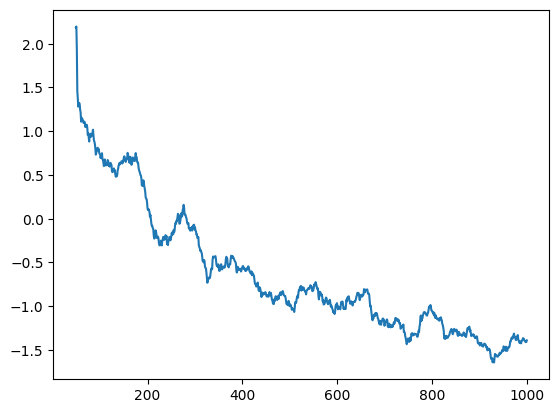

In [1665]:
sgld_model = StochasticVolatility(torch_data.shape, sigma_lambda=10., nu_lambda=0.1)
lr = 0.001
param_group_1 = [p for name, p in sgld_model.named_parameters() if name not in {'init_vol', 'sigma', 'nu'}]
param_group_2 = [sgld_model.init_vol]
param_group_3 = [sgld_model.sigma]
param_group_4 = [sgld_model.nu]

optimizer = SGLD(sgld_model.parameters(), lr=lr)
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
#                                        lr_lambda=lambda epoch: compute_lr(epoch, start=lr, end=0.0001))

epoch = 0
sgld_loss_seq = []
for epoch in range(1000):
    sgld_model.zero_grad()
    
    r_samples, vol_samples = sgld_model()
    loss = sgld_model.loss(torch_data, vol_samples)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(sgld_model.sigma, max_norm=50.)
    print(f'sgld_model.sigma.grad = {sgld_model.sigma.grad}')
    print(f'sgld_model.nu.grad = {sgld_model.nu.grad}')
        
    optimizer.step()
    #scheduler.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}, last_lr: {scheduler.get_last_lr()}')
    print(f'========================================')
    sgld_loss_seq.append(loss.item())
        
for name, param in sgld_model.named_parameters():
    print(f'{name} = {param}')
    if name in {'sigma', 'nu'}:
        print(f' * 1 / {name} = {1 / param}')

sgld_loss_seq = pd.Series(sgld_loss_seq)
sgld_loss_seq.rolling(50).mean().plot()

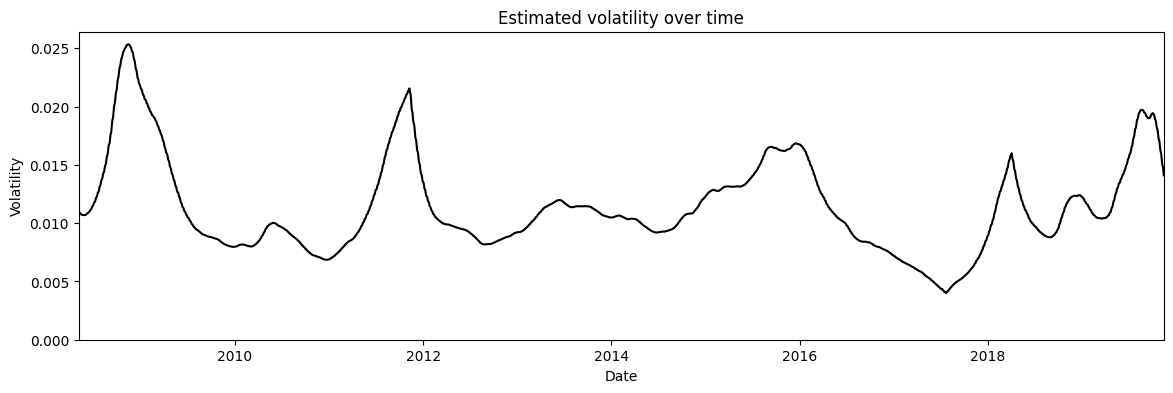

In [1666]:
sigma_rv = distributions.Exponential(sgld_model.sigma)
sigma_mean = sigma_rv.mean

vol_mean = sgld_model.init_vol + torch.cumsum(sgld_model.vol, dim=0) 

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_mean.cpu().detach().numpy())
x_vals = returns.index.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k")#, alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

# 2022-11-04

* Implemented the noise optimizer (I think it's working?)

TODO:

* Have to adjust the learning schedule accordingly, will have to figure out what that looks like...

# 2022-11-02

* To implement SGLD, I just really need to add in the noise term
    * I can do this by just inheriting from the Adam class and add the noise term.
* To implement the RMSProp (I'll be using ADAM) preconditioning, looks like I just need to adjust the learning rate
    * I should be able to modify my optimizer class

TODO:
* Implement the optimizer
* Figure out what LR schedule I actually need

# 2022-10-30

* I realized `nu` was off because it close to 2 (instead of the MAP in the model which is around 10)
* After further investigation, it looks like the mode of the posteriod (MAP estimate) shrinks `sigma` and `nu` (the random variables, not the parameters, which is the inverse) to 0.  So there must be a MODE collapse?
* Actually, this happened after I removed the `rsample()` from `nu` and `sigma`.  Adding them back probably slows the rate of decrease down, but probably not eliminates this effect.
* The priors for sure shrink them down to 0 (exponential distribution)
* It kind of looks like the likelihood also does as well?  
    * It's kind of hard to tell because of the indirection, but it's likely that it's at least true for `nu`, which wants to get "fatter" with a higher `nu`, which makes sense given that volatility is always relatively big and not close to 0.

# 2022-10-29

* Think I fixed it to work with batch updating:
    * Got rid of the superfluous `.expands()`
    * Loss: 
        * Priors operate directly on the parameters (NOT the reparameterized samples)
        * Had a bug where I was not using the diff as a prior (because I was using samples, not parameter values)
    * Use ADAM -- this was really important!  I got something *close* to the shape of HMC once every 10 runs or so.  Switching to ADAM, I pretty much the same shape every time.  It makes sense since the parameters probably have such different gradients due to the long chain, and probably having their own learning rates really makes a big difference.
    
TODO:
* Clean up code
* Move on to try SGLD, probably will need that extension paper where they use RMSProp instead of preconditioning matrix.
    
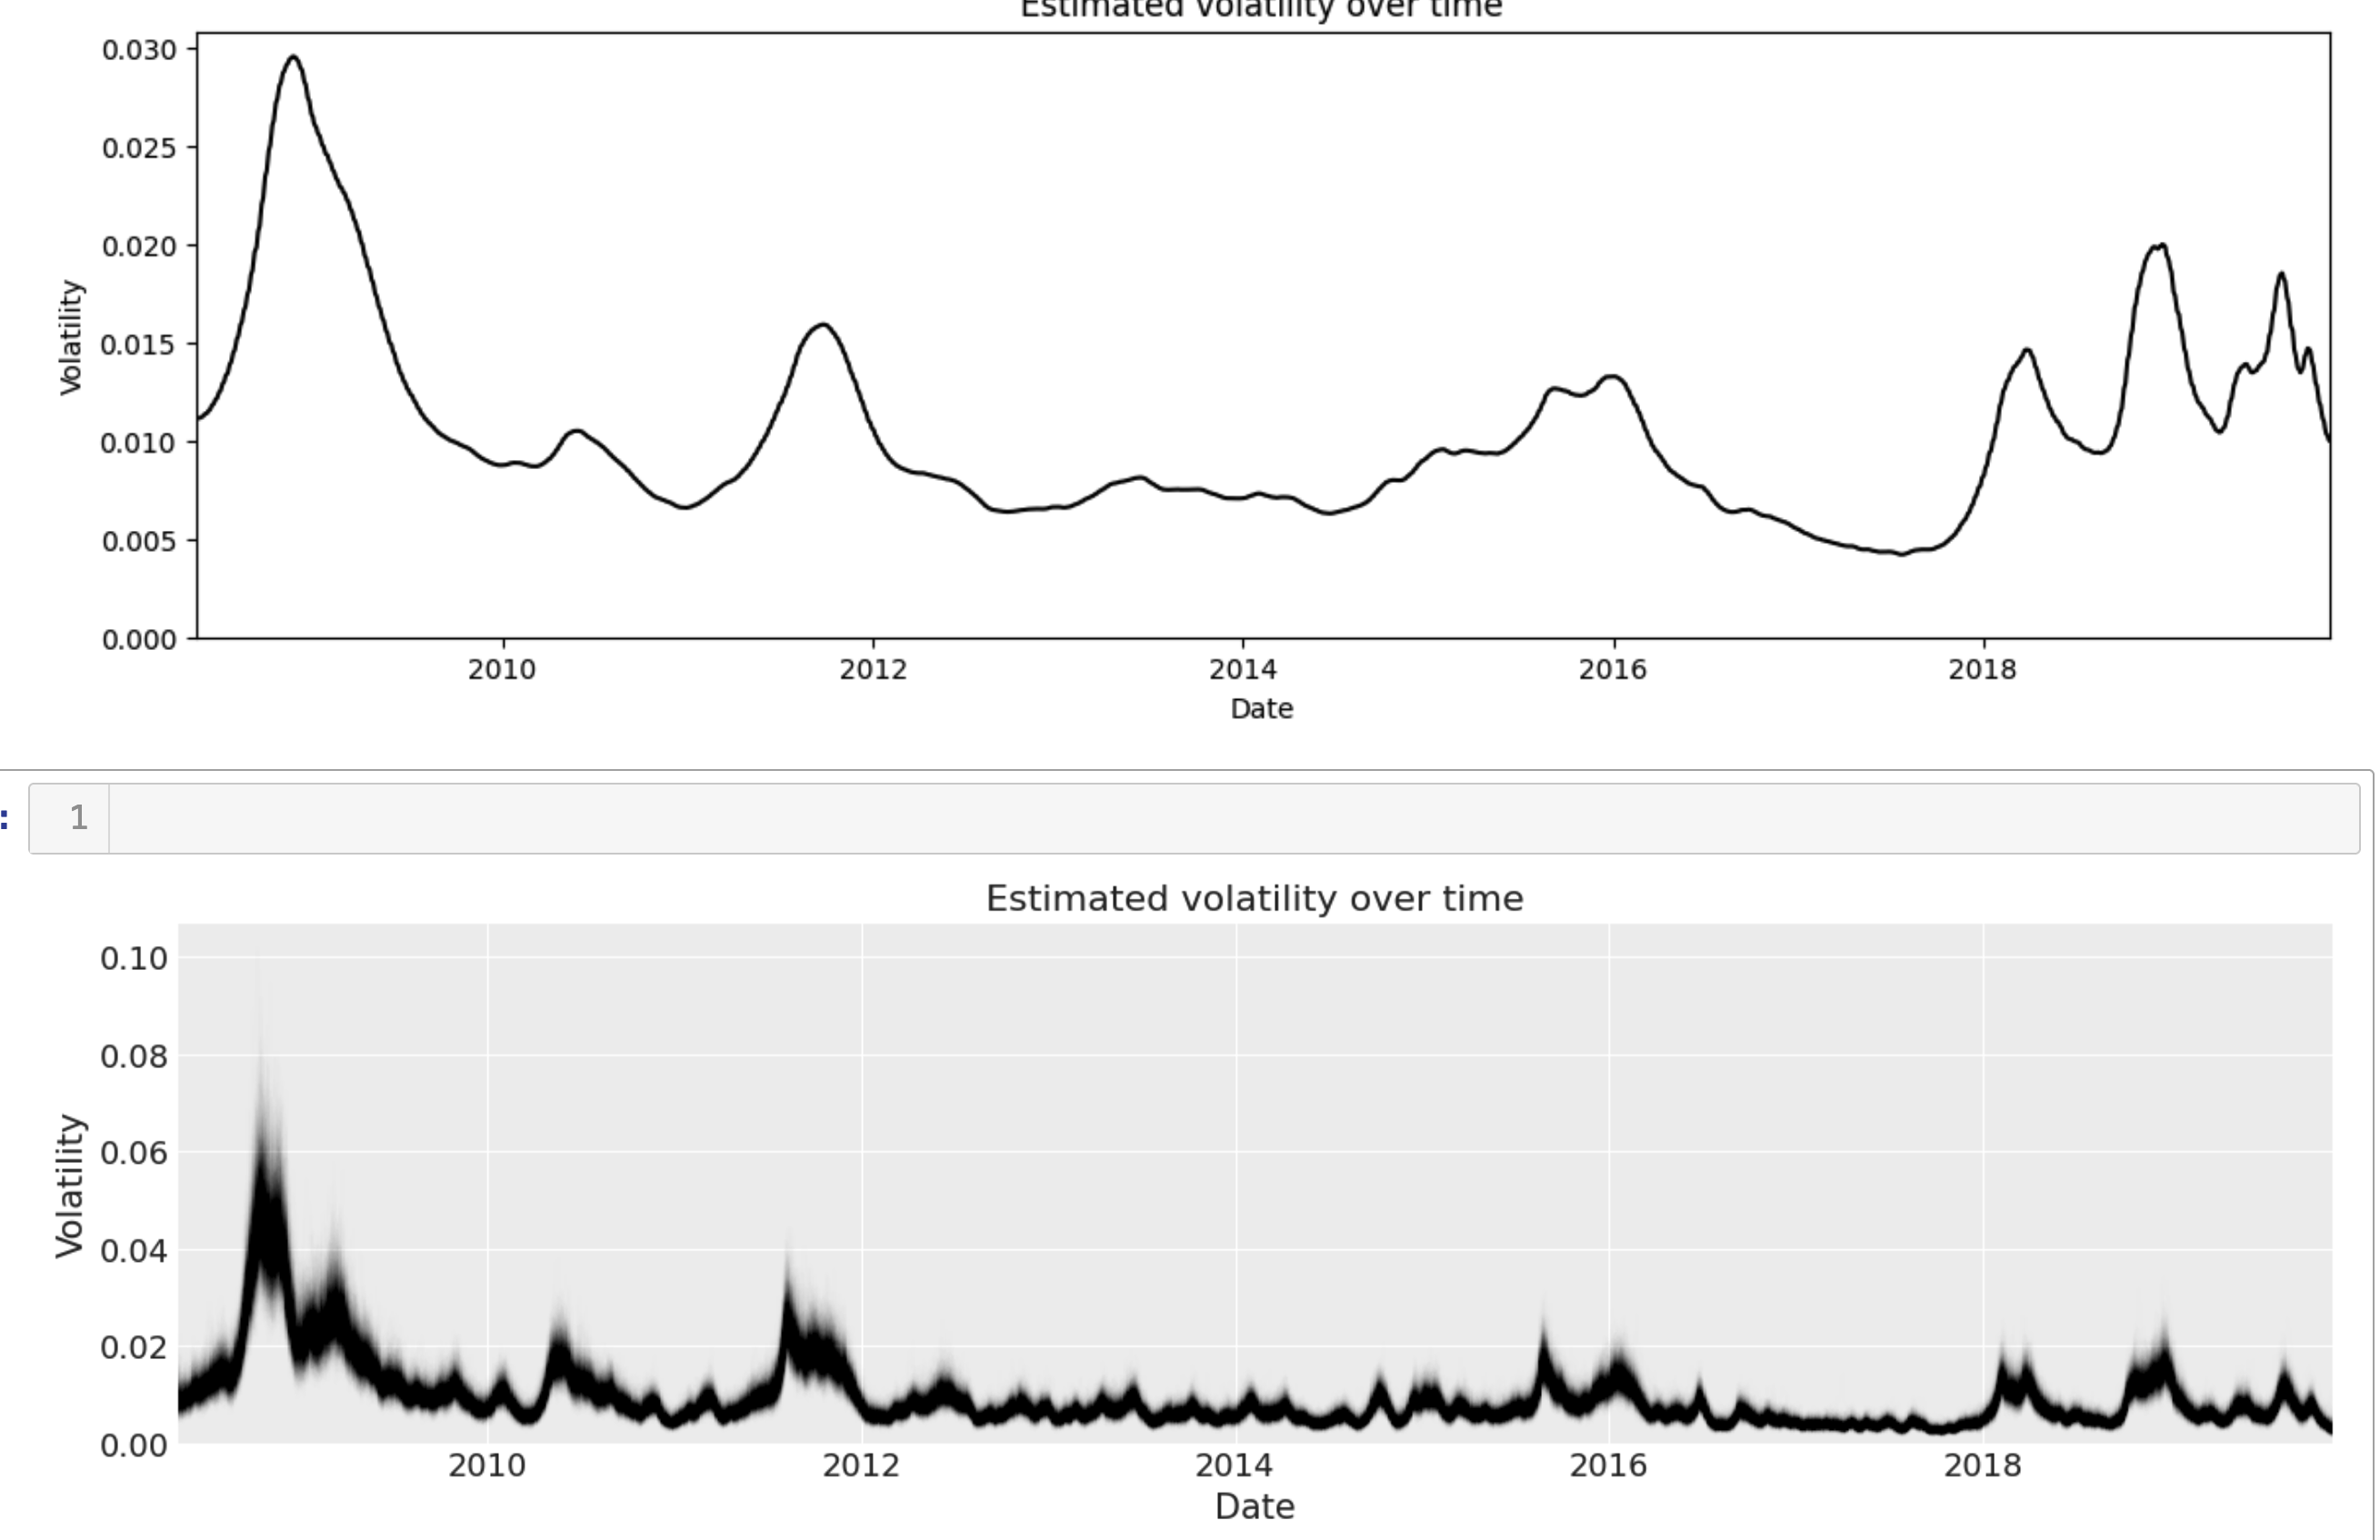


# 2022-10-24

* Fixed up some things in batch implementation, don't use `expand()` because it may have been not back proping through (not sure about that)
    * But using the cleaner method of just using `rsample(sample_size=...)` instead to generate batch needed
* Results still look kind of wrong since I can't mimic the stochastic volatility shape anymore (but the `lambda` and `nu` parameters are very close to the HMC modes / MAP).

TODO:
* Validate each of the batch calculations to make sure I'm generating the right value

# 2022-10-23

* Added `rsample()` to degrees freedom
* With the new changes it gets to the right place... sometimes:
    * There is a lot of variance based on the samples that are drawn from `rsample` and sometimes I get a low-ish loss that is similar in shape, sometimes I get something totally off
* I tried implementing "batch-ing" to average over multiple draws, but it doesn't seem to be learning that fast.

TODO:
* Validate my batch-ing implementation and figure out why it's not learning very fast

# 2022-10-22

* Found another conceptual difference.  I need to sample from each random variable in my DAG using `::rsample()`.
  * So the actual parameters in my torch model are simply the parameters of the random variables (e.g. `sigma` is rate of my exponential step size dist, `self.vol` is mean for the random walk gaussians etc.)
  * So to do a forward pass, I sample from rate, then I sample from vol, then I sample from t-dist (and sample from degrees freedom somewhere)
  * This fixed a lot of issues:
       * We can now backprop all the way through to `self.sigma` instead of only through prior regularizer
       * Misintepreted sigma to be the sample, NOT the rate parameter

TODO:
* Take a look at results in more detail
* May have to do SGD batch-like behavior so that we can smooth the gradient updates (and to smooth the `rsamples`)

# 2022-10-20

* Realized `self.vol` was really just the differences between normal distributions, so the prior can just be evaluated using the $N(0, \sigma^2)$ distribution, simplifying the logic
* I realized the initial value of the Gaussian random walk matters a lot, otherwise there is a discontinuity in the first time step, which throws everything off.  I set it at roughly $log(0.01)$, which is close to the first value I see in the MCMC simulation. 
    * It roughly follows the shape of the posterior from MCMC
    * The scale is off though, most likely because $\sigma$ is very small -- still need to figure out what the deal with that is.
    
    
TODO:
* It also looks like the `vol_init` changes very slowly (along with DF).  Why is that?
    * Is this a case of vanishing gradient (it has to backprop through ~3000 timesteps)?
* Why does $\sigma$ always tend towards negative?  Still need to figure this out...


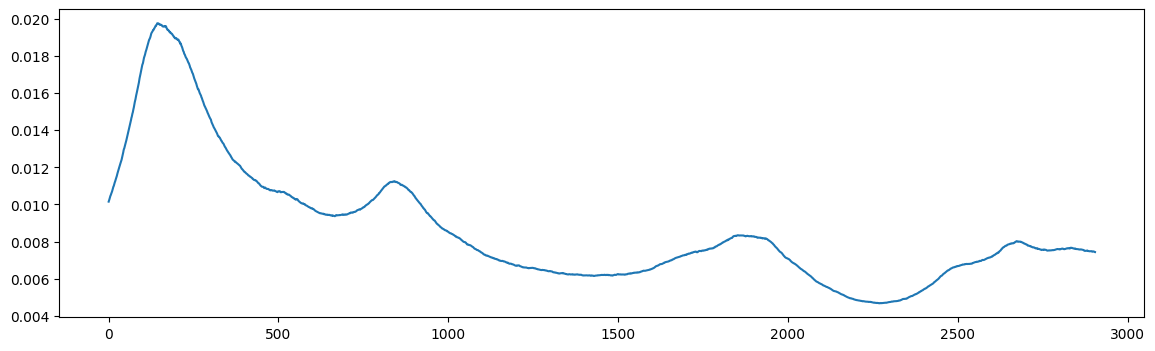

# 2022-10-15

* Fixed: Prior should not be multiplied by len(trace) because $P(X,Y|Z)P(Z) = P(X|Z) P(Y|Z)P(Z)$ where $X$ and $Y$ are conditionally independent given $Z$.  So we only need on prior ($Z$) not one for each of $X,Y$
* Did more debugging, seems like instability in gradient is causing some of my problems
    * See the gradient on sigma blows up for some reason.  Maybe this is like the RNN kind of problem with gradient instability and long traces (we do have a trace of ~3000)

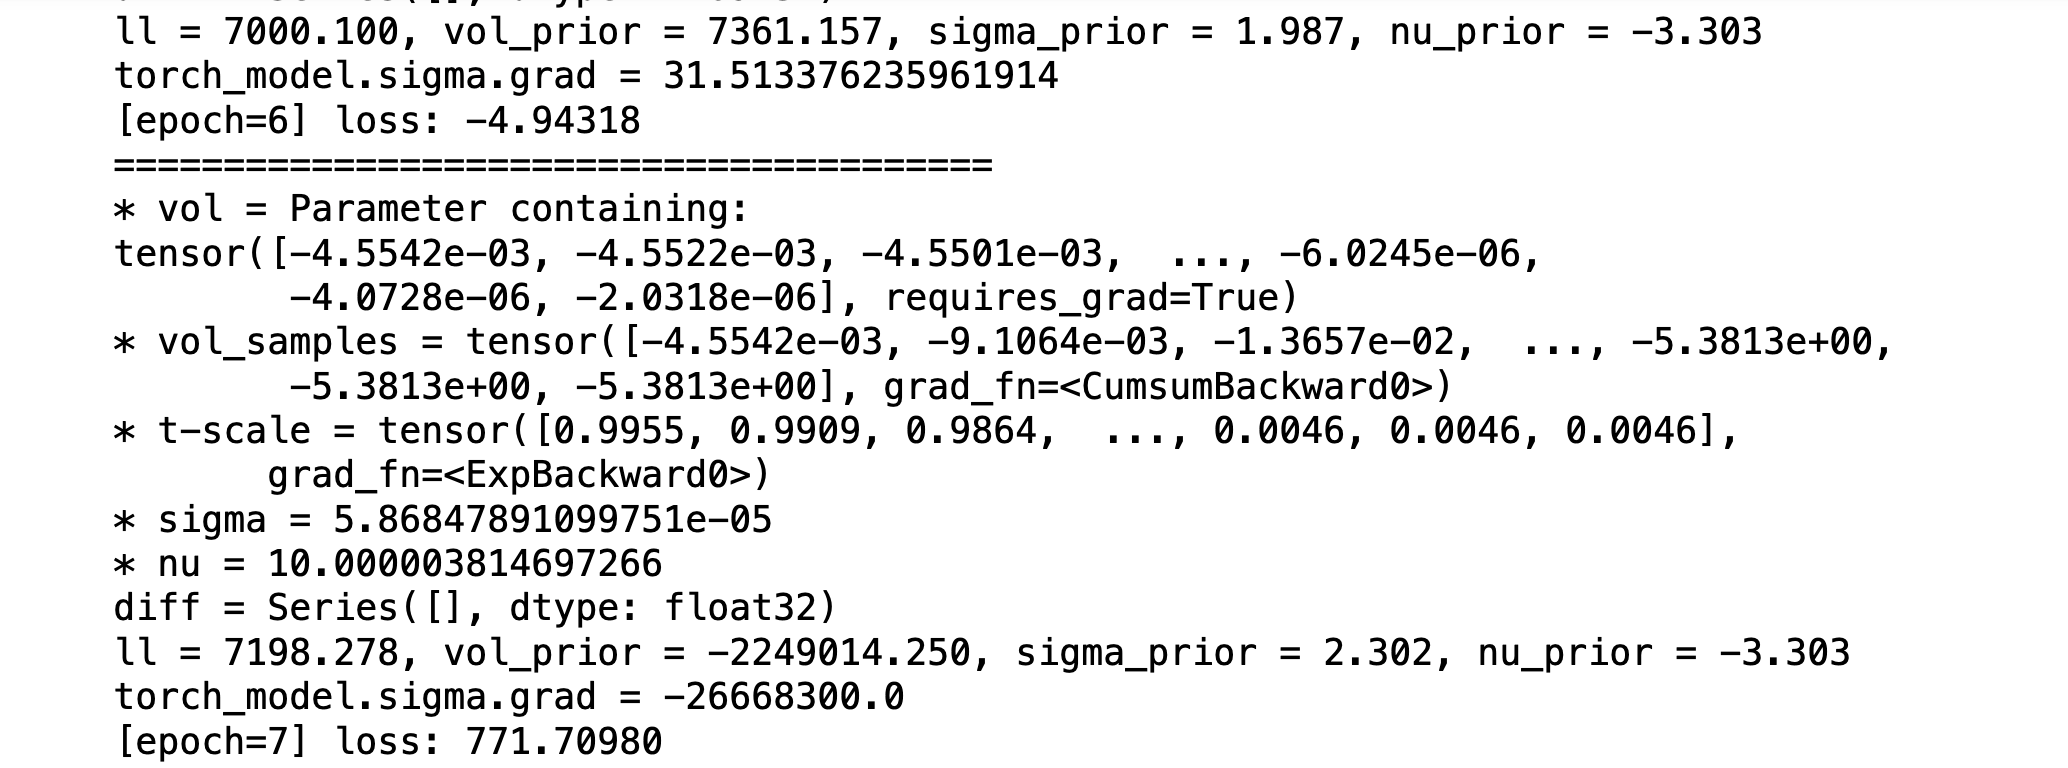

# 2022-10-10

* Had the modelling wrong, I need a Torch parameter for *each* latent variable in the model (not just the top level sigma/nu).  This means I need one for each step of the volatility random walk.
  * I also had a little bug with the reparameterization of t-dist from lambda to sigma (since they are inverse square of each other)
* Got it working, but... I still sometimes get negative values for \sigma since Torch doesn't care if it can eventually go negative.  I think the solution is to re-write it in terms of log(X) where X ~ exponentially distributed. See: https://math.stackexchange.com/questions/2244210/distribution-of-logx-for-exponentially-distributed-x
  * I did a hack by just taking ABS value of sigma, but that doesn't seem right.  Gradient seems off.
* Yeah the gradient of sigma gets huge after it gets close to 0, so I think I need the log parameterization or else the gradient is just going to be crazy.


TODO: 
* Use the log(X) trick to make sure \sigma doesn't go negative
* Double check logic again, sigma keeps going more negative, which is kind of odd why that would happen

# 2022-10-08

* Got the basic framework up for model in PyTorch
* Looks like $sigma$ is going negative though which causes error when used as scale for Gaussian

TODO:

* Double check the model specification, found errors in different parameterization of scales (in Normal and Gaussian)
* Also check loss function is doing what I think it should be...